<a href="https://colab.research.google.com/github/rianders/mtnlpxlmsentiment/blob/main/SentimentAnalysisAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Notebook

This notebook reviews the translation quality and the sentiment score accuracy. Which is used to determine how accurate sentiment or how much sentiment is retained in the machine translation process.

Paper and Code stored in Github Repo:
https://github.com/rianders/mtnlpxlmsentiment


# Machine Translation evaluation

We want to use BLEU or charF as a translation measure especially because Marian MT provides that information for the models we use for translation.  Doing this allows us measure translation score with the sentiment score and see if there is a meaningful relationship.

Here's how Marian MT uses:
BLEU

https://github.com/marian-nmt/sacreBLEU

chrF, chrF++

https://huggingface.co/spaces/evaluate-metric/chrf

These methods are in the sacrebleu library. So we can use that to get the chrF information.

However, these are run on the entire corpus. So judging indivual sentences will have to be done seperately to see if their score matters.

One thing we're trying to keep in mind is that clearly wrong translations won't give a valid sentiment.



Since we have accurate starting information we don't need to clean it before processing. Other kinds of data sets would need to consider how to clean the information.

We'll review the text statistics for each machine translator against the original information before translation.

Now we can measure how wrong a translation.
* Dr. Carmela Scala reviewed and scored the translatios for accuracy
* Does it make sense.




## Prepare the data


In [ ]:
#Global imports

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings('ignore')


## Fetch the data

In [ ]:
#prepare the data for use in evaluateing machine translation with BLEU and chrF

link = 'https://raw.githubusercontent.com/rianders/mtnlpxlmsentiment/main/data/SentinmentALL-20230508.csv'
print(link)
df_source = pd.read_csv(link,index_col=0)
df_source.head()
df_source.info()



https://raw.githubusercontent.com/rianders/mtnlpxlmsentiment/main/data/SentinmentALL-20230508.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Number                           169 non-null    int64  
 1   Italian                          167 non-null    object 
 2   Original                         169 non-null    int64  
 3   English_opus-mt-tc-big-it-en     169 non-null    object 
 4   English_Google                   169 non-null    object 
 5   rating_score                     169 non-null    float64
 6   rating_opus-mt                   169 non-null    float64
 7   NLTKPositive                     169 non-null    float64
 8   NLTKNegative                     169 non-null    float64
 9   NLTKNeutral                      169 non-null    float64
 10  NLTKSentiment                    169 non-null   

## Clean the data

In [ ]:
df_source = df_source.drop(index=[0])
df_source = df_source.drop(63)

In [ ]:
df_source = df_source.rename(columns={'Opus': 'Correct_opus-mt-tc-big-it', 'Google': 'Correct_google', 'Original':'Original_sentiment', 'rating_score':'rating_score-gt'})


In [ ]:
# Fix the BLEU score field
df_source[["BLEU_score_mt", "BLEU_score_gt"]].iloc[0:1]

# mt BLEU score is a text field of a bunch of dta and all we want is the score\
df_source['BLEU_score_mt'] = df_source['BLEU_score_mt'].str.extract(r'(\d+\.\d+)').astype(float)
df_source['BLEU_score_gt'] = df_source['BLEU_score_gt'].str.extract(r'(\d+\.\d+)').astype(float)




In [ ]:
# Review corrected
df_source[["BLEU_score_mt", "BLEU_score_gt"]].iloc[0:4]

,BLEU_score_mt,BLEU_score_gt
1,100.0,100.00
2,100.0,100.00
3,100.0,43.47
4,100.0,42.73


In [ ]:
# fix the chrF score from text to float
df_source['chrF_score_mt'] = df_source['chrF_score_mt'].str.extract(r'chrF2 = (\d+\.\d+)').astype(float)
df_source['chrF_score_gt'] = df_source['chrF_score_gt'].str.extract(r'chrF2 = (\d+\.\d+)').astype(float)



In [ ]:
# Review corrected
df_source[["chrF_score_mt", "chrF_score_gt"]].iloc[0:4]

,chrF_score_mt,chrF_score_gt
1,100.0,100.00
2,100.0,100.00
3,100.0,74.37
4,100.0,68.87


In [ ]:
# Rename the columns in the df_source DataFrame
df_source = df_source.rename(columns={
    'rating_score-gt': 'VADER_google_sa',
    'rating_opus-mt': 'VADER_marian_sa'
})

In [ ]:
df_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 1 to 168
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Number                           167 non-null    int64  
 1   Italian                          167 non-null    object 
 2   Original_sentiment               167 non-null    int64  
 3   English_opus-mt-tc-big-it-en     167 non-null    object 
 4   English_Google                   167 non-null    object 
 5   VADER_google_sa                  167 non-null    float64
 6   VADER_marian_sa                  167 non-null    float64
 7   NLTKPositive                     167 non-null    float64
 8   NLTKNegative                     167 non-null    float64
 9   NLTKNeutral                      167 non-null    float64
 10  NLTKSentiment                    167 non-null    float64
 11  NLTKPositive-G                   167 non-null    float64
 12  NLTKNegative-G        

In [ ]:
# Add column for the length of the Marian MT translated sentences
df_source['len_mt'] = df_source['English_opus-mt-tc-big-it-en'].str.len()

# Add column for the length of the Google translated sentences
df_source['len_gt'] = df_source['English_Google'].str.len()



## Review the quality of translation and split into seperate data sets

In [ ]:
original_row_count = len(df_source)
print(f"Original rows/translations: {original_row_count}")

print("The count of good and bad translations for Google:")
df_source["Correct_google"].value_counts()


Original rows/translations: 167
The count of good and bad translations for Google:


True     91
False    76
Name: Correct_google, dtype: int64

In [ ]:
print("The count of good and bad translations for mt:")
df_source["Correct_opus-mt-tc-big-it"].value_counts()


The count of good and bad translations for mt:


True     119
False     48
Name: Correct_opus-mt-tc-big-it, dtype: int64

In [ ]:
# Masks for good translations
mask_google_true = df_source['Correct_google'] == True
mask_opus_true = df_source['Correct_opus-mt-tc-big-it'] == True
mask_both_true = (df_source['Correct_google'] == True) & (df_source['Correct_opus-mt-tc-big-it'] == True)


In [ ]:
# variation on the data set for good translatione
df_google_true = df_source[mask_google_true]
df_opus_true = df_source[mask_opus_true]
df_both_true = df_source[mask_both_true]


In [ ]:
# Count the remaining "true" good translated rows for each translation engine
google_count = df_google_true.shape[0]
opus_count = df_opus_true.shape[0]
both_count = df_both_true.shape[0]

In [ ]:
# how much data is left after only select good translations
print(f"Number of rows in df_google_true: {df_google_true.shape[0]}")
print(f"Number of rows in df_opus_true: {df_opus_true.shape[0]}")
print(f"Number of rows in df_both_true: {df_both_true.shape[0]}")

Number of rows in df_google_true: 91
Number of rows in df_opus_true: 119
Number of rows in df_both_true: 65


## Visialize the data qualities for each translation and find the both true

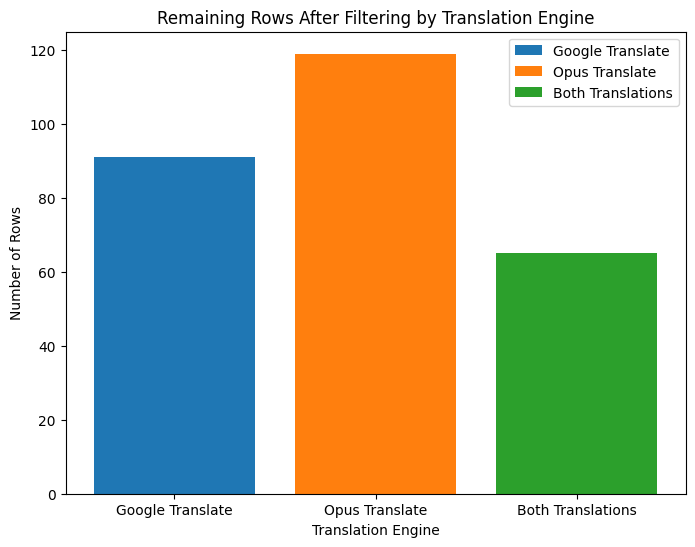

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(8,6))

# Create a stacked bar chart of remaining rows for each translation engine
plt.bar(["Google Translate"], google_count, label="Google Translate")
plt.bar(["Opus Translate"], opus_count, label="Opus Translate")
plt.bar(["Both Translations"], both_count, label="Both Translations")

# Set the plot title and axis labels
plt.title("Remaining Rows After Filtering by Translation Engine")
plt.xlabel("Translation Engine")
plt.ylabel("Number of Rows")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()




## Translation accuracter viusalization

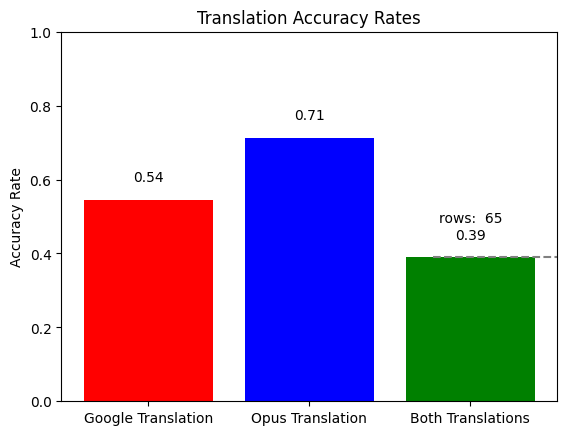

In [ ]:
import matplotlib.pyplot as plt

# calculate accuracy rates
google_accuracy = df_google_true['Correct_google'].sum() / df_source.shape[0]
opus_accuracy = df_opus_true['Correct_opus-mt-tc-big-it'].sum() / df_source.shape[0]
both_accuracy = df_both_true['Correct_opus-mt-tc-big-it'].sum() / df_source.shape[0]

# create a bar chart
labels = ['Google Translation', 'Opus Translation', 'Both Translations']
accuracy_rates = [google_accuracy, opus_accuracy, both_accuracy]
colors = ['red', 'blue', 'green']
plt.bar(labels, accuracy_rates, color=colors)
plt.title('Translation Accuracy Rates')
plt.ylabel('Accuracy Rate')
plt.ylim(0, 1)

# add text labels for the accuracy rates
for i, rate in enumerate(accuracy_rates):
    plt.text(i, rate + 0.05, f'{rate:.2f}', ha='center')

# add a vertical line to highlight the size of df_both_true
plt.axhline(y=both_accuracy, xmin=0.75, xmax=1, color='gray', linestyle='--')
# plt.text(2, both_accuracy + 0.05, f' {df_both_true.shape[0]}', ha='center')
plt.text(2, both_accuracy + 0.05, f'rows:  {df_both_true.shape[0]}\n', ha='center')


plt.show()

Starting from a total of total of 167 sentences. We have 65 sentences that are correct in translation. Thirty nine percent of the sentences were accurate from both data sets. We will use these sentences in the remaining analysis. The official source data frame is now df_both_true. That way we are measureing the good translations here on out.

In [ ]:
#Review the format
df_both_true.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 1 to 154
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Number                           65 non-null     int64  
 1   Italian                          65 non-null     object 
 2   Original_sentiment               65 non-null     int64  
 3   English_opus-mt-tc-big-it-en     65 non-null     object 
 4   English_Google                   65 non-null     object 
 5   VADER_google_sa                  65 non-null     float64
 6   VADER_marian_sa                  65 non-null     float64
 7   NLTKPositive                     65 non-null     float64
 8   NLTKNegative                     65 non-null     float64
 9   NLTKNeutral                      65 non-null     float64
 10  NLTKSentiment                    65 non-null     float64
 11  NLTKPositive-G                   65 non-null     float64
 12  NLTKNegative-G         

## Review the "gold" or "true" sentiment  and sentence information

### Word Cloud Summary of the different data sets

We want to get a visual idea of the words visluaized as word clouds from the df_source and the df_both_true data frames.

In [ ]:
# This takes in a data frame, and column and create a word cloud
from typing import Union
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datetime import datetime


nltk.download('punkt')
nltk.download('stopwords')

# Do we have stop words like this for the original Italian?

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords_italian = set(nltk.corpus.stopwords.words('italian'))

def create_word_cloud(df: pd.DataFrame, column: Union[str, int], description: str, language: str = 'english') -> None:
    # Print the description
    print(description)

    # Create a string containing all of the text from the specified column
    text = ' '.join(df[column])

    # Tokenize the text
    word_tokens = word_tokenize(text)

    # Remove stop words
    if language == 'english':
        filtered_text = [w for w in word_tokens if not w in stopwords]
    elif language == 'italian':
        filtered_text = [w for w in word_tokens if not w in stopwords_italian]

    # get current date and time
    now = datetime.now()

    # format the datetime string to be used as a filename (YYYYMMDD_HHMMSS)
    datetime_str = now.strftime("%Y%m%d_%H%M%S")

    file_name = f'filtered_text_{datetime_str}.txt'

    with open(file_name, 'w', encoding='utf-8') as f:
        f.write(' '.join(filtered_text))



    # Create a word cloud using the filtered text
    wordcloud = WordCloud().generate(' '.join(filtered_text))

    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()







[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Word Cloud for Italian Text:


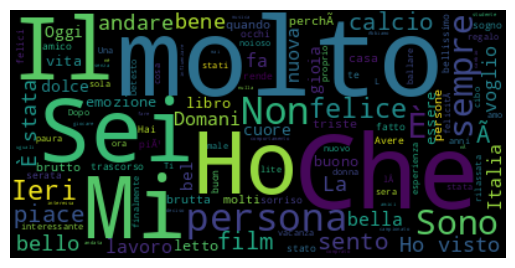

Word Cloud for English_Google Text:


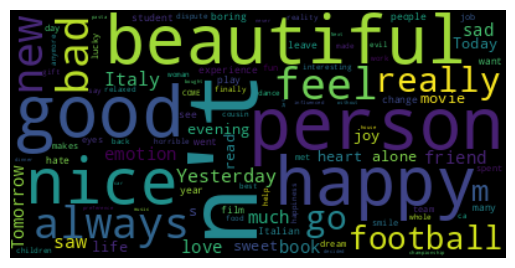

Word Cloud for English_opus-mt-tc-big-it-en Text in df_opus_true:


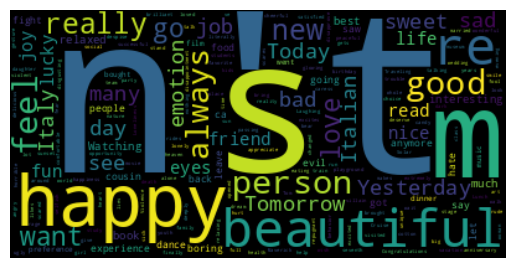

Word Cloud for English_Google Text in df_google_true:


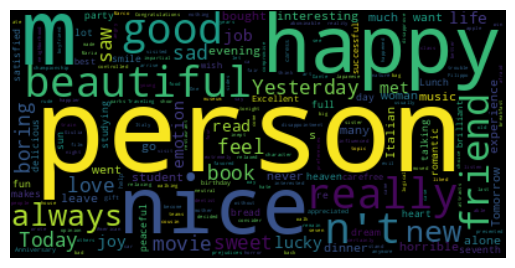

Word Cloud for English_Google Text in df_both_true:


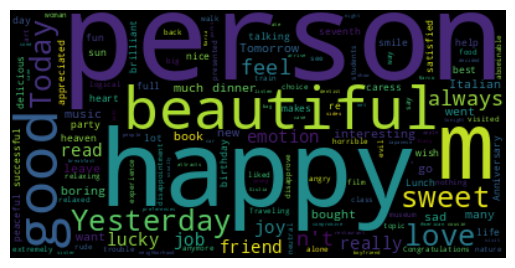

Word Cloud for English_opus-mt-tc-big-it-en Text in df_both_true:


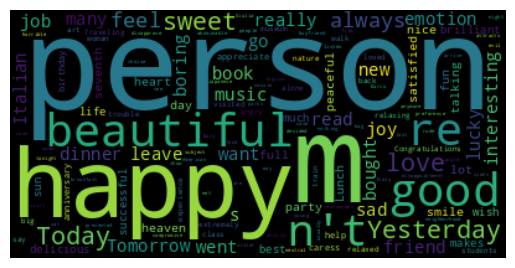

In [ ]:
# Create a word cloud for the 'Italian' column in the original DataFrame
create_word_cloud(df_source, 'Italian', 'Word Cloud for Italian Text:','italian')
## Check this for the correct orginal sentences ## Check which this is pulled from.

# In Italian the articles are showing up instead of the subjects
# The stop words are showing up
# We didn't ignore any of the words

# Create a word cloud for the 'English_Google' column in the original DataFrame
create_word_cloud(df_source, 'English_Google', 'Word Cloud for English_Google Text:', 'english')

# Create a word cloud for the 'English_opus-mt-tc-big-it-en' column in the df_opus_true DataFrame
create_word_cloud(df_opus_true, 'English_opus-mt-tc-big-it-en', 'Word Cloud for English_opus-mt-tc-big-it-en Text in df_opus_true:', 'english')

# Create a word cloud for the 'English_Google' column in the df_google_true DataFrame
create_word_cloud(df_google_true, 'English_Google', 'Word Cloud for English_Google Text in df_google_true:', 'english')

# Create a word cloud for the 'English_Google' column in the df_both_true DataFrame
create_word_cloud(df_both_true, 'English_Google', 'Word Cloud for English_Google Text in df_both_true:', 'english')

# Create a word cloud for the 'English_opus-mt-tc-big-it-en' column in the df_both_true DataFrame
create_word_cloud(df_both_true, 'English_opus-mt-tc-big-it-en', 'Word Cloud for English_opus-mt-tc-big-it-en Text in df_both_true:', 'english')




### Length of sentences

<Axes: >

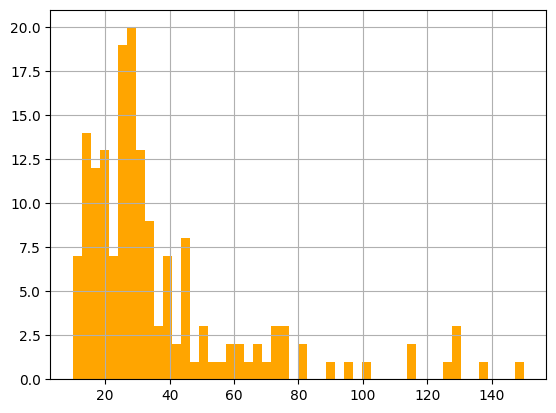

In [ ]:
# Calculate length of Italian sentences
df_source['len'] = df_source['Italian'].str.len()

# plot the histogram of content length from the original data frame
df_source['len'].hist(bins=50, color='orange')


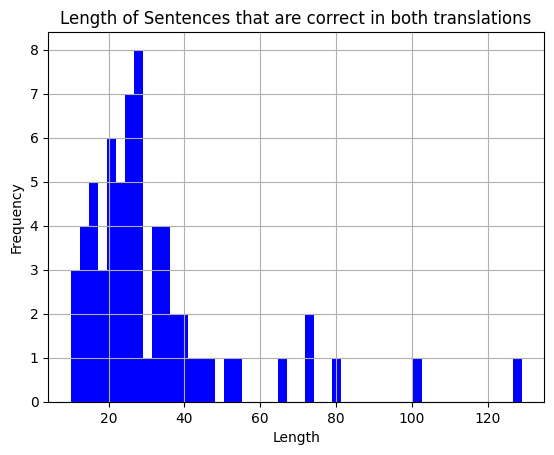

In [ ]:
# Create a new column with the length of the Italian text in the df_both_true DataFrame
df_both_true['len'] = df_both_true['Italian'].str.len()

#
df_both_true['len'].hist(bins=50, color='blue')
plt.title("Length of Sentences that are correct in both translations")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()



### Word counts

In [ ]:
# Add the word_count column
# df = df.assign(word_count=df["Italian"].str.split().str.len())
# Add word_count column to df_both_true DataFrame
df_both_true['word_count'] = df_both_true['Italian'].str.split().str.len()

# Add word_count column to df_source DataFrame
df_source['word_count'] = df_source['Italian'].str.split().str.len()

# Display the first few rows of both DataFrames with necessary columns
print("df_both_true:")
print(df_both_true.loc[:, ['Italian', 'len', 'word_count']].head())
print("\ndf_source:")
print(df_source.loc[:, ['Italian', 'len', 'word_count']].head())



df_both_true:
                                   Italian  len  word_count
1                              Sono felice   11           2
2  Ieri alla festa mi sono divertita molto   39           7
3             È stato bello parlare con te   28           6
5               Oggi è una giornata serena   26           5
6                   Sono al settimo cielo!   22           4

df_source:
                                   Italian  len  word_count
1                              Sono felice   11           2
2  Ieri alla festa mi sono divertita molto   39           7
3             È stato bello parlare con te   28           6
4            Ho trascorso una bella serata   29           5
5               Oggi è una giornata serena   26           5


<Axes: >

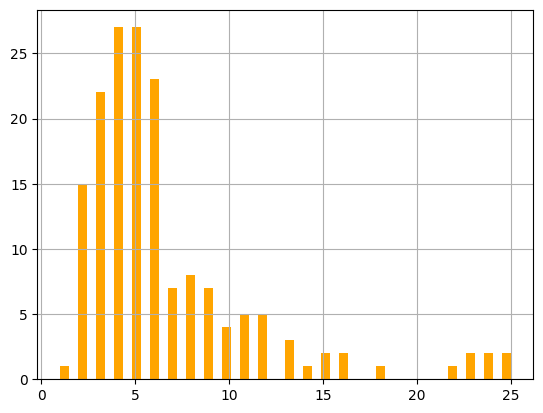

In [ ]:
df_source['word_count'].hist(bins=50, color='orange')


<Axes: >

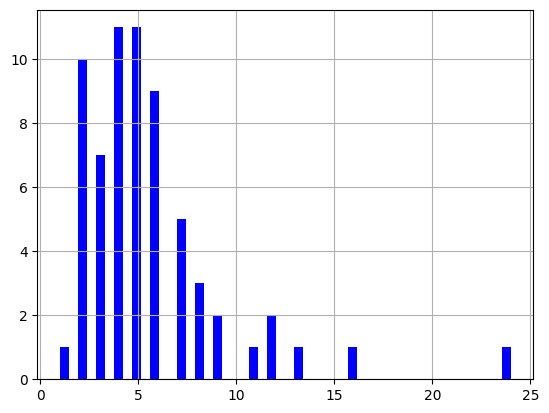

In [ ]:
df_both_true['word_count'].hist(bins=50, color='blue')


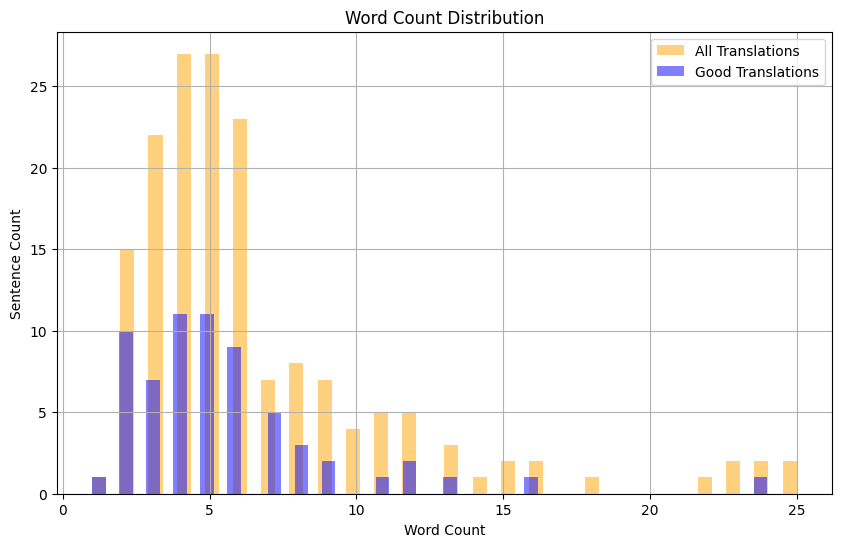

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the word_count histogram from df_source
df_source['word_count'].hist(bins=50, color='orange', alpha=0.5, label='All Translations')

# Plot the word_count histogram from df_both_true
df_both_true['word_count'].hist(bins=50, color='blue', alpha=0.5, label='Good Translations')

# Set the plot title and axis labels
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Sentence Count')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


### Longest sentences and word counts

In [ ]:
# What is the longest sentence
df_source.sort_values(by="word_count", ascending=False, inplace=True)

# Print the longest sentence
print(df_source["Italian"].head(1).values[0])

L' esperienza studio in Italia  è stata unica. Mi ha cambiato letteralmente la vita e mi ha aperto gli occhi su una nuova realtÃ .


In [ ]:
# What is the longest sentence
df_both_true.sort_values(by="word_count", ascending=False, inplace=True)

# Print the longest sentence
print(df_both_true["Italian"].head(1).values[0])

Mi sento una donna molto fortunate perchÃ¨ faccio un lavoro che amo e quando sono in classe con mi miei studenti mi sento felice.


In [ ]:
# get the count of entries with each length
length_counts = df_source['len'].value_counts()

# sort the counts in descending order
length_counts = length_counts.sort_values(ascending=False)

# print the length counts
print(f"df_source: {length_counts}")

df_source: 27     9
25     7
28     7
24     6
30     6
      ..
130    1
37     1
17     1
43     1
12     1
Name: len, Length: 64, dtype: int64


In [ ]:
# get the count of entries with each length
length_counts = df_both_true['len'].value_counts()

# sort the counts in descending order
length_counts = length_counts.sort_values(ascending=False)

# print the length counts
print(f"df_both_true: {length_counts}")

df_both_true: 20     4
25     4
27     4
26     3
28     3
16     3
14     3
33     2
39     2
32     2
35     2
15     2
36     2
23     2
18     2
22     2
21     2
11     2
44     1
37     1
101    1
38     1
30     1
55     1
46     1
29     1
43     1
51     1
24     1
65     1
80     1
19     1
13     1
72     1
73     1
10     1
129    1
Name: len, dtype: int64


### "Gold" or "True" sentiment review of total sentences and the good quality translations

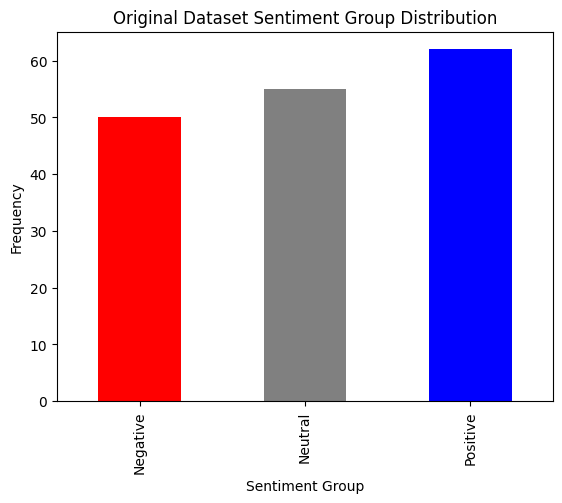

In [ ]:
## True/Gold standard sentiment value
# Assigns a group name to each sentiment
def get_sentiment_group(sentiment):
    if sentiment == -1:
        return 'Negative'
    elif sentiment == 0:
        return 'Neutral'
    elif sentiment == 1:
        return 'Positive'

# Apply the function to the "original" column and assign the result to a new column called "true_sentiment"
df_source['true_sentiment'] = df_source['Original_sentiment'].apply(get_sentiment_group)

# Get the count of entries with each group
group_counts = df_source['true_sentiment'].value_counts()

group_counts.head()

# Plot the bar chart
ax = group_counts.sort_index().plot.bar(color=['red', 'gray', 'blue'])

# Set the plot title and axis labels
plt.title('Original Dataset Sentiment Group Distribution')
plt.xlabel('Sentiment Group')
plt.ylabel('Frequency')

# Show the plot
plt.show()


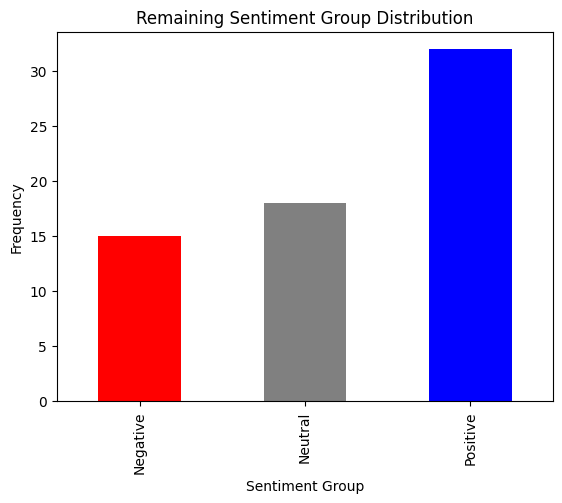

In [ ]:
# Apply the function to the "original" column and assign the result to a new column called "true_sentiment"
df_both_true['true_sentiment'] = df_both_true['Original_sentiment'].apply(get_sentiment_group)

# Get the count of entries with each group
group_counts = df_both_true['true_sentiment'].value_counts()

group_counts.head()

# Plot the bar chart
ax = group_counts.sort_index().plot.bar(color=['red', 'gray', 'blue'])

# Set the plot title and axis labels
plt.title('Remaining Sentiment Group Distribution')
plt.xlabel('Sentiment Group')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### Sentence length by sentiment group

---> Trouble with these graphs. Neutral should not have outliers.

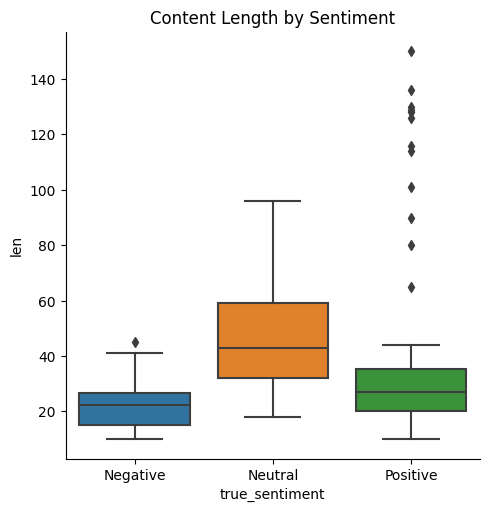

In [ ]:
# define the desired order of the sentiment groups
sentiment_order = ['Negative', 'Neutral', 'Positive']

# plot a box plot comparing the content length by sentiment values.
sns.catplot(data=df_source, y="len", x="true_sentiment", kind="box", order=sentiment_order)

# Add a title to the plot
plt.title("Content Length by Sentiment")

# Show the plot
plt.show()

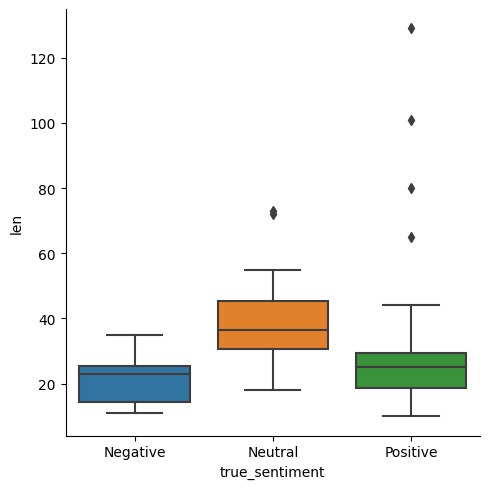

In [ ]:
# define the desired order of the sentiment groups
sentiment_order = ['Negative', 'Neutral', 'Positive']

# plot a box plot comparing the content length by sentiment values.
sns.catplot(data=df_both_true, y="len", x="true_sentiment", kind="box", order=sentiment_order)

In [ ]:
# Sort the DataFrame by sentence length
df_source.sort_values(by="len", ascending=False, inplace=True)

# Print the 5 longest sentences
df_source["Italian"].head()

53    Domani si sposa mio cugino ed io non vedo lÂo...
58    Una delle esperienze più belle della mia vita ...
60    L' esperienza studio in Italia  è stata unica....
61    Mi sento una donna molto fortunate perchÃ¨ fac...
59    Ho visto il nuovo film di Tom Cruise, ÂMaveri...
Name: Italian, dtype: object

In [ ]:
# Sort the DataFrame by sentence length
df_both_true.sort_values(by="len", ascending=False, inplace=True)

# Print the 5 longest sentences
df_both_true["Italian"].head()

61     Mi sento una donna molto fortunate perchÃ¨ fac...
62     Ieri ho visitato un museo d'arte molto interes...
52     Viaggiare in treno da sola è un esperienza bel...
133    In questo caso entrambe le parti hanno deciso ...
121    Il film ha presentato l'argomento in una manie...
Name: Italian, dtype: object

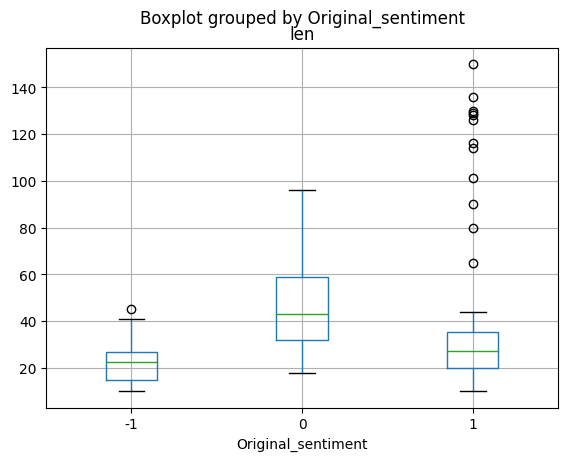

In [ ]:
# Create a box plot
ax = df_source.boxplot(column="len", by="Original_sentiment")

# Show the plot
plt.show()

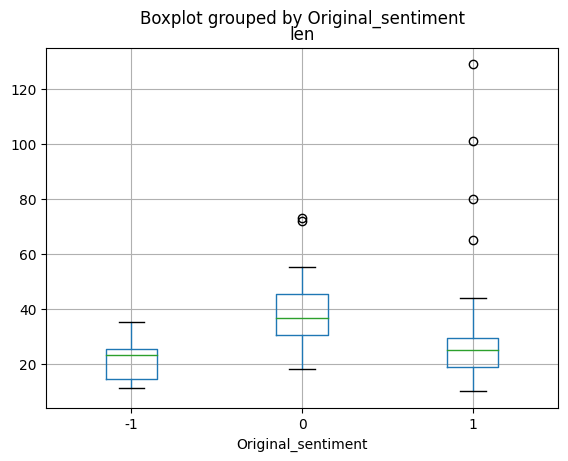

In [ ]:
# Create a box plot
ax = df_both_true.boxplot(column="len", by="Original_sentiment")

# Show the plot
plt.show()

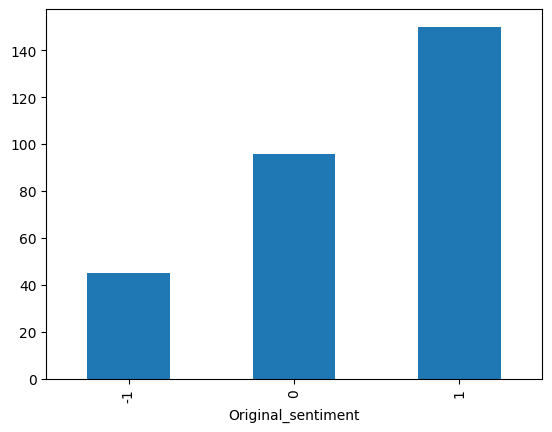

In [ ]:
# Calculate the maximum length of the sentences for each sentiment value
sentiment_length = df_source.groupby("Original_sentiment")["len"].max()

# Create a bar plot
sentiment_length.plot(kind="bar")

# Show the plot
plt.show()

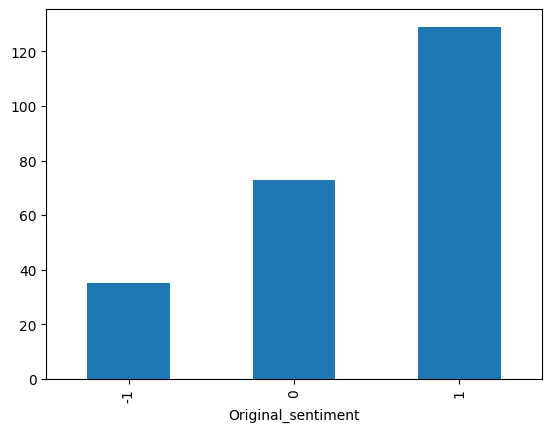

In [ ]:
# Calculate the maximum length of the sentences for each sentiment value
sentiment_length = df_both_true.groupby("Original_sentiment")["len"].max()

# Create a bar plot
sentiment_length.plot(kind="bar")

# Show the plot
plt.show()

opus-mt-tc-big-it-en
https://huggingface.co/Helsinki-NLP/opus-mt-tc-big-it-en


In [ ]:
# Compare between the two in a graph

### Word Frequency


In [ ]:
# need to graph the bigram, trigram etc values



# preprocessing of the translated text: lower case; tokenize; remove stopwords
def tokenize(text):
    return nltk.word_tokenize(text)




def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


# count the token frequencies of the two translators

from collections import Counter
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

# Count the ngrams
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

def create_bigram_heatmap(df, title, annot=True, figsize=(12, 12), cmap='YlGnBu'):
    # Pivot the DataFrame to create a matrix for the heatmap
    bigram_matrix = df.pivot_table(index='first_word', columns='second_word', values='freq', fill_value=0)

    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(bigram_matrix, annot=annot, fmt='d', cmap=cmap)

    # Customize the plot
    plt.title(title)
    plt.xlabel('Second Word')
    plt.ylabel('First Word')

    # Show the plot
    plt.show()

In [ ]:
df_source['tokens'] = df_source['English_Google'].apply(lambda x: prepare(x, pipeline))
df_source['bigrams'] = df_source['tokens'].apply(lambda x: ngrams(x, n=2, stopwords=stopwords))
bigram_freq_df_total = count_words(df_source, column='bigrams', min_freq=2)

bigram_freq_df_total['first_word'] = bigram_freq_df_total.index.str.split(' ').str[0]
bigram_freq_df_total['second_word'] = bigram_freq_df_total.index.str.split(' ').str[1]
bigram_freq_df_total.reset_index(drop=True, inplace=True)



In [ ]:
# Combine the English_Google and English_opus-mt-tc-big-it-en columns into one
good_translations_text = ' '.join(df_both_true['English_Google'] + ' ' + df_both_true['English_opus-mt-tc-big-it-en'])

# Tokenize the text and get bigrams
good_tokens = tokenize(good_translations_text)
good_bigrams = ngrams(good_tokens, n=2, sep=' ', stopwords=stopwords)

# Create a DataFrame with the bigrams
good_bigram_df = pd.DataFrame(good_bigrams, columns=['bigram'])

# Count the frequency of the bigrams
bigram_freq_df_good = count_words(good_bigram_df, column='bigram', min_freq=2)

# Split the bigram tokens into separate columns for 'first_word' and 'second_word'
bigram_freq_df_good['first_word'] = bigram_freq_df_good.index.str.split(' ').str[0]
bigram_freq_df_good['second_word'] = bigram_freq_df_good.index.str.split(' ').str[1]
bigram_freq_df_good.reset_index(drop=True, inplace=True)


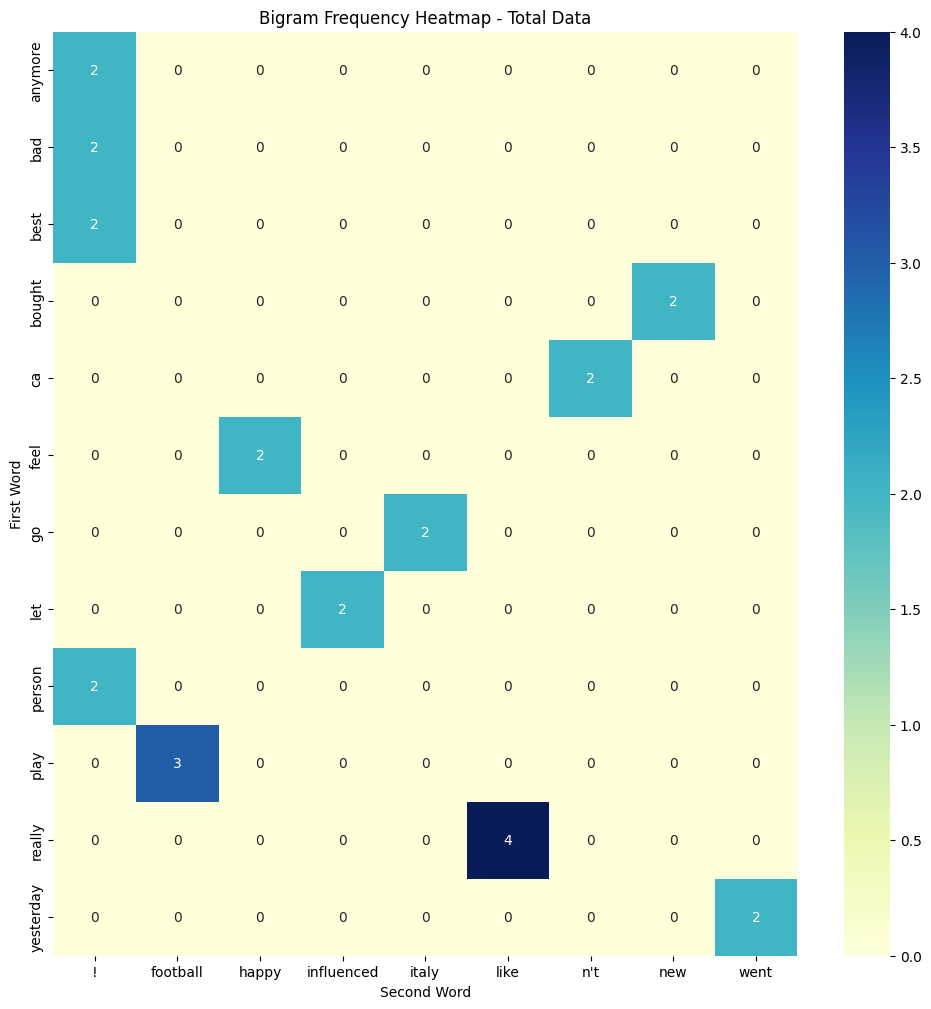

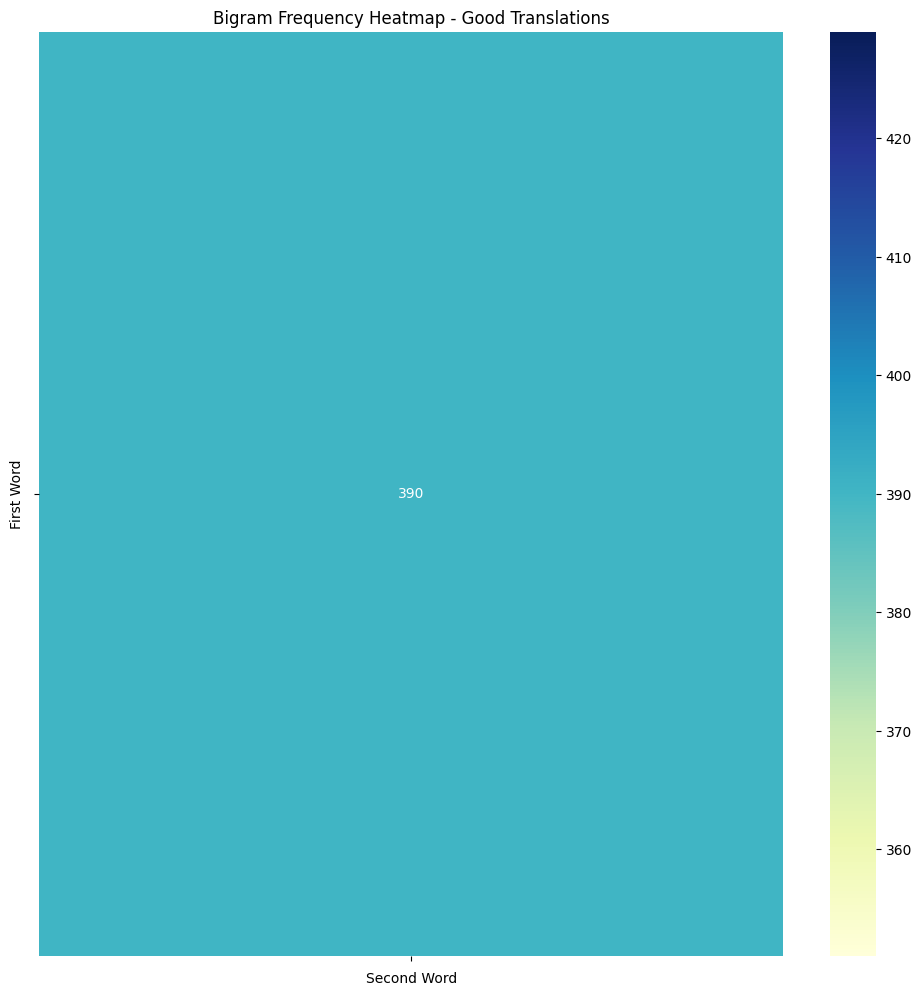

In [ ]:
# These graphs don't work and need to be replaced with something showing this better.
# Box plot

create_bigram_heatmap(bigram_freq_df_total, title='Bigram Frequency Heatmap - Total Data')
create_bigram_heatmap(bigram_freq_df_good, title='Bigram Frequency Heatmap - Good Translations')

In [ ]:
# Calculate the lengths of the translated sentences
df_source['len_mt'] = df_source['English_opus-mt-tc-big-it-en'].str.len()
df_source['len_google'] = df_source['English_Google'].str.len()

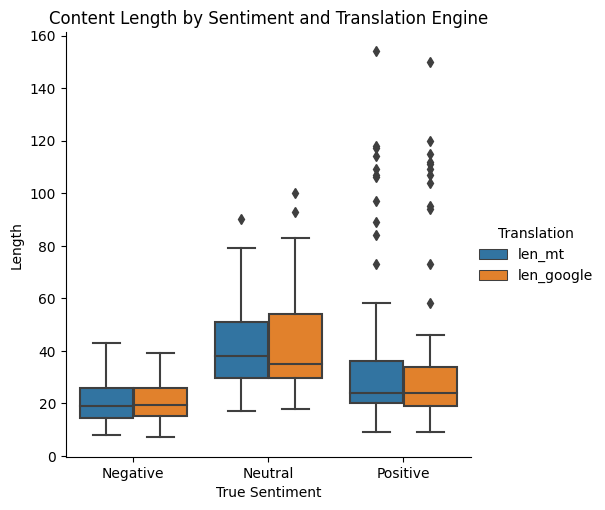

In [ ]:
# Create a side-by-side box plot comparing the content length by translation engines.
df_source_melted = df_source.melt(id_vars="true_sentiment", value_vars=["len_mt", "len_google"], var_name="Translation", value_name="Length")
sns.catplot(data=df_source_melted, x="true_sentiment", y="Length", hue="Translation", kind="box", order=sentiment_order)

# Set the plot title and axis labels
plt.title("Content Length by Sentiment and Translation Engine")
plt.xlabel("True Sentiment")
plt.ylabel("Length")

# Show the plot
plt.show()


In [ ]:
# Calculate the lengths of the translated sentences
df_both_true['len_mt'] = df_both_true['English_opus-mt-tc-big-it-en'].str.len()
df_both_true['len_google'] = df_both_true['English_Google'].str.len()

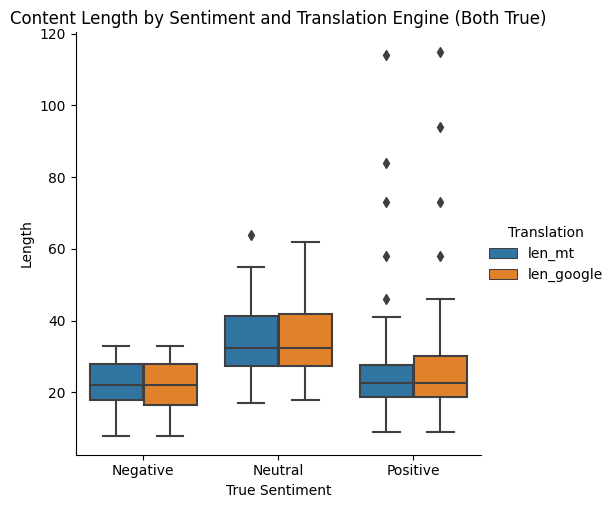

In [ ]:
df_both_true_melted = df_both_true.melt(id_vars="true_sentiment", value_vars=["len_mt", "len_google"], var_name="Translation", value_name="Length")
sns.catplot(data=df_both_true_melted, x="true_sentiment", y="Length", hue="Translation", kind="box", order=sentiment_order)

# Set the plot title and axis labels
plt.title("Content Length by Sentiment and Translation Engine (Both True)")
plt.xlabel("True Sentiment")
plt.ylabel("Length")

# Show the plot
plt.show()

### Section Conclusion

Google Translate had 91 good translations, while Opus Translate had 119 good translations. This indicates that Opus Translate performed slightly better in terms of translation quality in this specific dataset.

There were 65 instances where both Google Translate and Opus Translate had good translations. This suggests that there is some overlap in the quality of translations between the two engines.

What did we observe from the word clouds?

What can be determined from the categories, length, frequencey, and other data comparing the full data set with the dataset where both translations are good?

Let's move to evaluate the translations by trnalastion engine.



## Marian MT Italian to English Translation

### Evaluate this translation



In [ ]:
#BLEU and chrF values

# Review that they are in our data set

print("df_source:")
print(df_source[['BLEU_score_mt', 'chrF_score_mt']].head())

print("\ndf_both_true:")
print(df_both_true[['BLEU_score_mt', 'chrF_score_mt']].head())


df_source:
    BLEU_score_mt  chrF_score_mt
53         100.00         100.00
58          35.82          64.91
60         100.00         100.00
61         100.00         100.00
59         100.00         100.00

df_both_true:
     BLEU_score_mt  chrF_score_mt
61           100.0          100.0
62           100.0          100.0
52           100.0          100.0
133          100.0          100.0
121          100.0          100.0


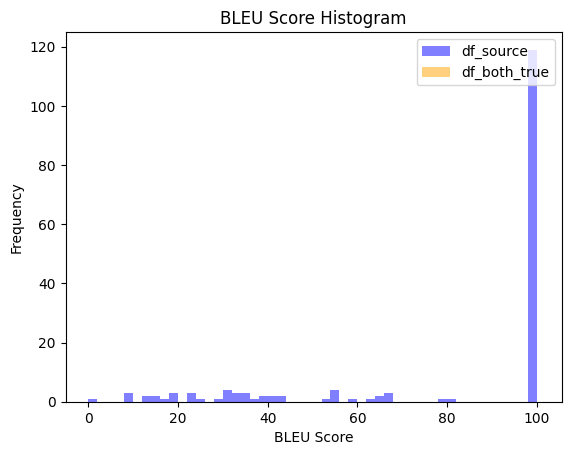

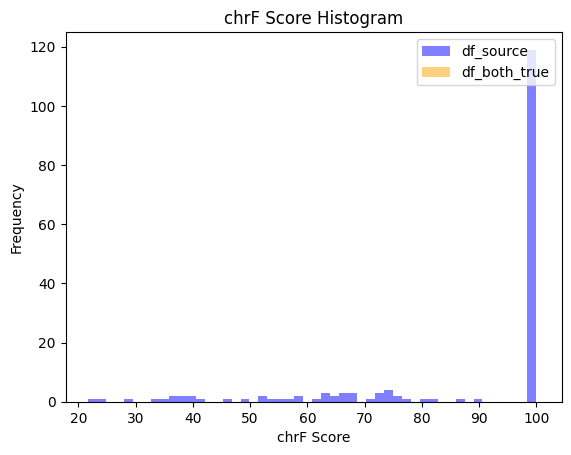

In [ ]:
plt.hist(df_source['BLEU_score_mt'], bins=50, alpha=0.5, label='df_source', color='blue')
plt.hist(df_both_true['BLEU_score_mt'], bins=50, alpha=0.5, label='df_both_true', color='orange')
plt.legend(loc='upper right')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Score Histogram')
plt.show()

plt.hist(df_source['chrF_score_mt'], bins=50, alpha=0.5, label='df_source', color='blue')
plt.hist(df_both_true['chrF_score_mt'], bins=50, alpha=0.5, label='df_both_true', color='orange')
plt.legend(loc='upper right')
plt.xlabel('chrF Score')
plt.ylabel('Frequency')
plt.title('chrF Score Histogram')
plt.show()


In [ ]:
print(df_both_true['BLEU_score_mt'].describe())
print(df_both_true['chrF_score_mt'].describe())



count     65.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: BLEU_score_mt, dtype: float64
count     65.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: chrF_score_mt, dtype: float64


#### Text length


<Axes: >

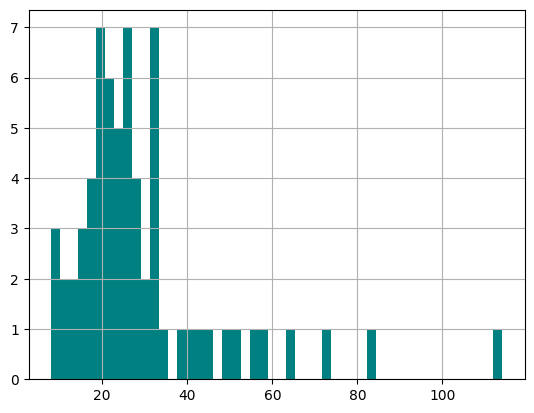

In [ ]:
# Length distribution for Marian MT
df_both_true['len_mt'].hist(bins=50, color="teal")


#### Word Frequeny
importance


<Axes: >

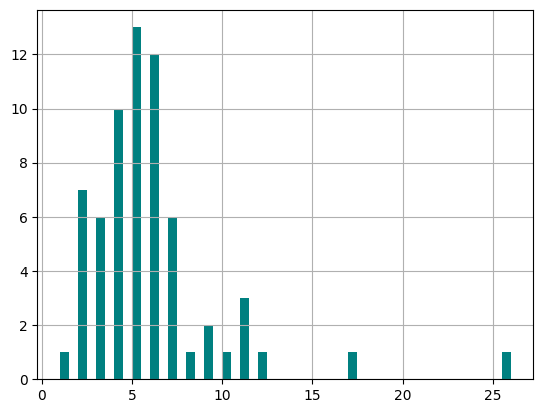

In [ ]:
df_both_true = df_both_true.assign(word_count_mt=df_both_true["English_opus-mt-tc-big-it-en"].str.split().str.len())
df_both_true['word_count_mt'].hist(bins=50, color="teal")



In [ ]:
# Word frequency pipeline to MT Tokens
df_both_true['MT_tokens'] = df_both_true['English_opus-mt-tc-big-it-en'].apply(prepare, pipeline=pipeline)


In [ ]:
MT_freq = count_words(df_both_true, column='MT_tokens')

#Top 15 tokens
MT_top = list(MT_freq.head(15).reset_index().token)
print(MT_top)

['!', '.', 'person', "'m", 'happy', 'beautiful', "n't", 'good', "'re", 'today', 'like', 'always', 'feel', 'yesterday', 'love']


[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'MT Top Words')]

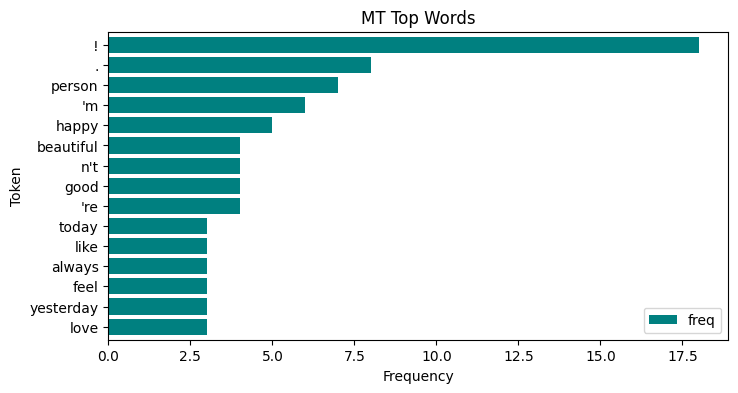

In [ ]:
# Show's stop words and extra characters
# visualize most frequent words using barplots
ax = MT_freq.head(15).plot(kind='barh', width=0.8, figsize=(8,4),color='teal')
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='MT Top Words')


#### Word sequences
word sequences

In [ ]:
#MT Bigrams
df_both_true['MT_bigram'] = df_both_true['MT_tokens'].apply(ngrams, n=2, stopwords=stopwords)


[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'MT Top Bigrams')]

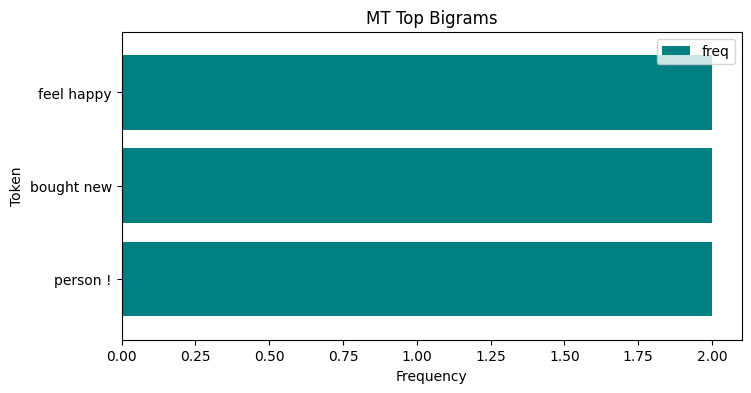

In [ ]:
ax = count_words(df_both_true, 'MT_bigram').head(10).plot(kind='barh', width=0.8, figsize=(8,4),color='teal')
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='MT Top Bigrams')



#### Overall Quality

The BLEU and chrF scores represent the assessed quality of translation. Were any of the accepted sentences rated lower than 100? What was the quality of the rejected sentences.

##### BLEI Scores graphed score, rejected, accepted

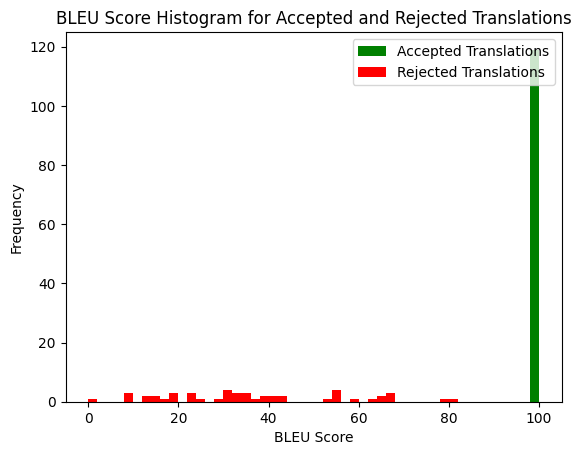

In [ ]:
# need the field to be boolean not just string
df_source['Correct_opus-mt-tc-big-it'] = df_source['Correct_opus-mt-tc-big-it'].astype(bool)


accepted_translations = df_source[df_source['Correct_opus-mt-tc-big-it']]['BLEU_score_mt'].astype(float)
rejected_translations = df_source[~df_source['Correct_opus-mt-tc-big-it']]['BLEU_score_mt'].astype(float)

plt.hist([accepted_translations, rejected_translations], bins=50, stacked=True, label=['Accepted Translations', 'Rejected Translations'], color=['green', 'red'])
plt.legend(loc='upper right')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Score Histogram for Accepted and Rejected Translations')
plt.show()


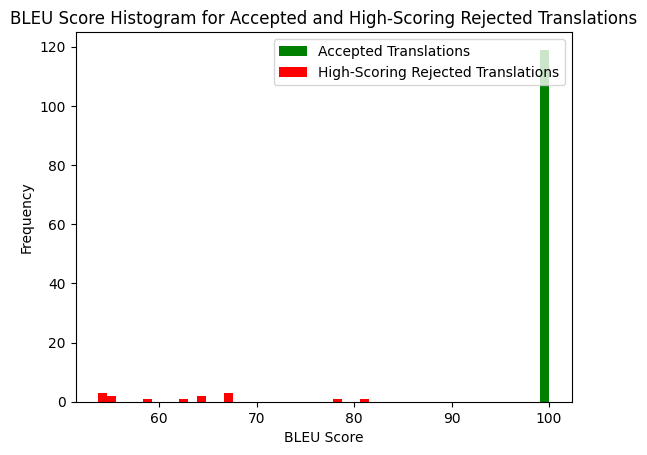

In [ ]:
high_score_threshold = 50

accepted_translations = df_source[df_source['Correct_opus-mt-tc-big-it']]['BLEU_score_mt'].astype(float)
rejected_translations = df_source[~df_source['Correct_opus-mt-tc-big-it'] & (df_source['BLEU_score_mt'].astype(float) > high_score_threshold)]['BLEU_score_mt'].astype(float)

plt.hist([accepted_translations, rejected_translations], bins=50, stacked=True, label=['Accepted Translations', 'High-Scoring Rejected Translations'], color=['green', 'red'])
plt.legend(loc='upper right')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Score Histogram for Accepted and High-Scoring Rejected Translations')
plt.show()


##### Graphs of the chrF score, accepted, rejected

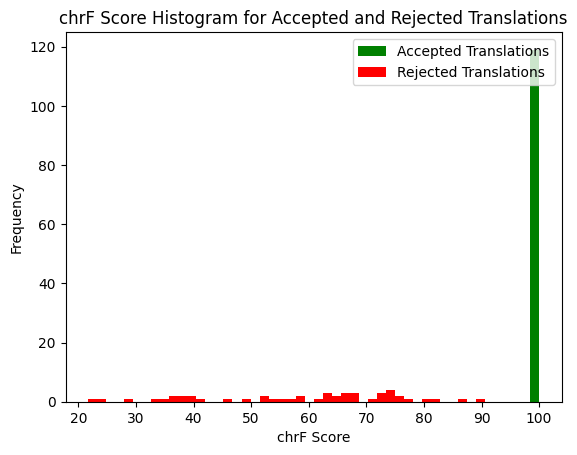

In [ ]:
# need the field to be boolean not just string
df_source['Correct_opus-mt-tc-big-it'] = df_source['Correct_opus-mt-tc-big-it'].astype(bool)

accepted_translations = df_source[df_source['Correct_opus-mt-tc-big-it']]['chrF_score_mt'].astype(float)
rejected_translations = df_source[~df_source['Correct_opus-mt-tc-big-it']]['chrF_score_mt'].astype(float)

plt.hist([accepted_translations, rejected_translations], bins=50, stacked=True, label=['Accepted Translations', 'Rejected Translations'], color=['green', 'red'])
plt.legend(loc='upper right')
plt.xlabel('chrF Score')
plt.ylabel('Frequency')
plt.title('chrF Score Histogram for Accepted and Rejected Translations')
plt.show()


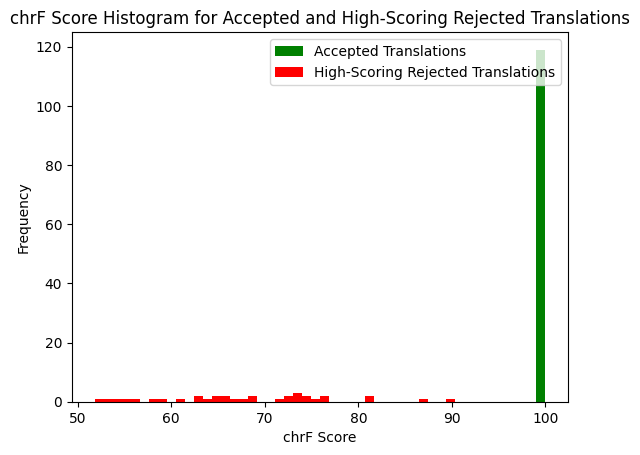

In [ ]:
high_score_threshold = 50

accepted_translations = df_source[df_source['Correct_opus-mt-tc-big-it']]['chrF_score_mt']
rejected_translations = df_source[~df_source['Correct_opus-mt-tc-big-it'] & (df_source['chrF_score_mt'] > high_score_threshold)]['chrF_score_mt']

plt.hist([accepted_translations, rejected_translations], bins=50, stacked=True, label=['Accepted Translations', 'High-Scoring Rejected Translations'], color=['green', 'red'])
plt.legend(loc='upper right')
plt.xlabel('chrF Score')
plt.ylabel('Frequency')
plt.title('chrF Score Histogram for Accepted and High-Scoring Rejected Translations')
plt.show()


In [ ]:
rejected_with_bleu_100 = df_source[(~df_source['Correct_opus-mt-tc-big-it']) & (df_source['BLEU_score_mt'] == 100)]
rejected_with_chrf_100 = df_source[(~df_source['Correct_opus-mt-tc-big-it']) & (df_source['chrF_score_mt'] == 100)]

print("Number of rejected translations with a BLEU score of 100:", len(rejected_with_bleu_100))
print("Number of rejected translations with a chrF score of 100:", len(rejected_with_chrf_100))


Number of rejected translations with a BLEU score of 100: 0
Number of rejected translations with a chrF score of 100: 0


The algorhtmic evaluation of the transalaton from the ideal sentence to the actual translation matched the accepted translations.


#### Examples of mistranslation

Is this section needed?

## Google Translate


### Evaluate this translation




In [ ]:
#BLEU and chrF values

# Review that they are in our data set

print("df_source:")
print(df_source[['BLEU_score_gt', 'chrF_score_gt']].head())

print("\ndf_both_true:")
print(df_both_true[['BLEU_score_gt', 'chrF_score_gt']].head())


df_source:
    BLEU_score_gt  chrF_score_gt
53          85.31          91.49
58         100.00         100.00
60          73.90          89.37
61          86.46          95.91
59          38.35          61.62

df_both_true:
     BLEU_score_gt  chrF_score_gt
61           86.46          95.91
62           72.00          87.79
52          100.00         100.00
133          73.49          92.21
121          73.49          82.33


#### Text lenth


<Axes: >

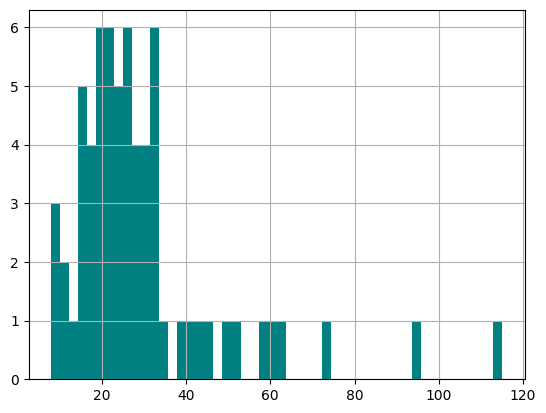

In [ ]:
# Length distribution for Google Translation
df_both_true['len_gt'].hist(bins=50, color="teal")



#### Word Frequeny



<Axes: >

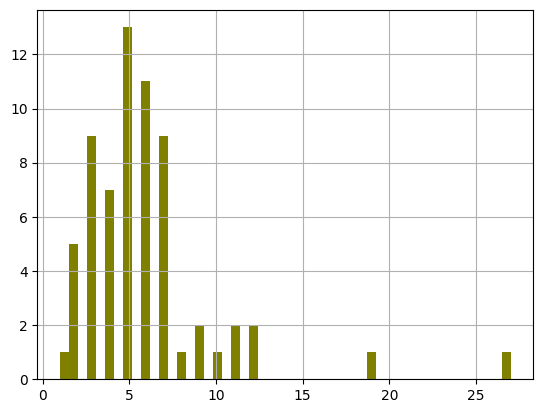

In [ ]:
# Word frequency
df_both_true = df_both_true.assign(word_count_gt=df_both_true["English_Google"].str.split().str.len())
df_both_true['word_count_gt'].hist(bins=50, color="olive")


['!', 'person', 'happy', "'m", '.', 'good', 'beautiful', 'sweet', "n't", 'today', 'like', 'always', 'feel', 'love', 'yesterday']


[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Google Translate Top Words (Both True)')]

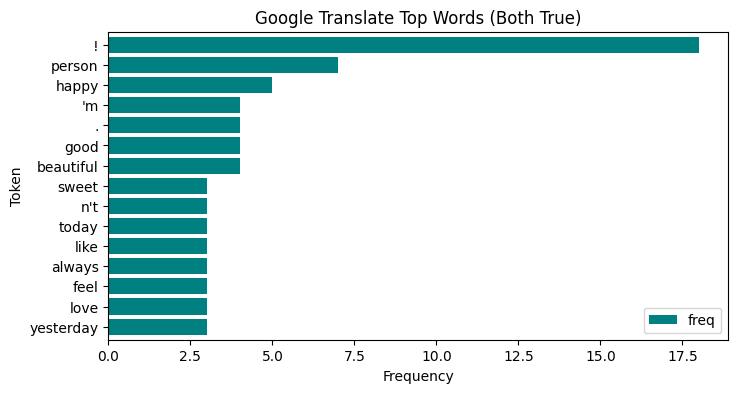

In [ ]:

# Word frequency pipeline to GT Tokens
df_both_true['GT_tokens'] = df_both_true['English_Google'].apply(prepare, pipeline=pipeline)

GT_freq_both_true = count_words(df_both_true, column='GT_tokens')

# Top 15 tokens
G_top_both_true = list(GT_freq_both_true.head(15).reset_index().token)
print(G_top_both_true)

# visualize most frequent words using barplots
ax = GT_freq_both_true.head(15).plot(kind='barh', width=0.8, figsize=(8,4),color='teal')
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Google Translate Top Words (Both True)')


#### Word Sequences



[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'GT Top Bigrams (Both True)')]

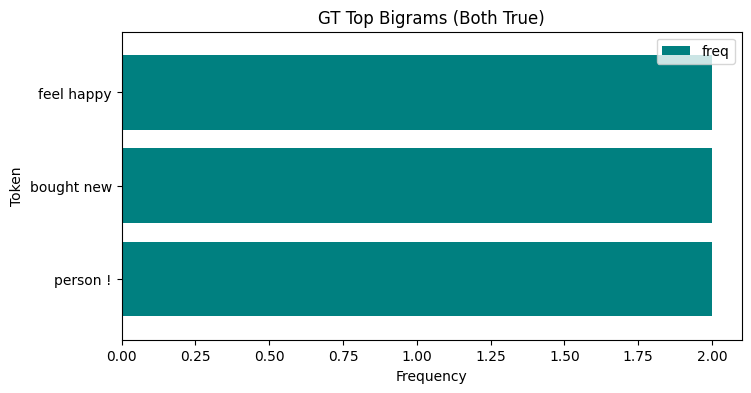

In [ ]:
# GT Bigrams
df_both_true['GT_bigram'] = df_both_true['GT_tokens'].apply(ngrams, n=2, stopwords=stopwords)



ax = count_words(df_both_true, 'GT_bigram').head(10).plot(kind='barh', width=0.8, figsize=(8, 4), color='teal')
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='GT Top Bigrams (Both True)')


#### Overall Quality

In [ ]:

# need the field to be boolean not just string
df_source['Correct_google'] = df_source['Correct_google'].astype(bool)


accepted_translations_gt = df_source[df_source['Correct_google']]['chrF_score_gt'].astype(float)
rejected_translations_gt = df_source[~df_source['Correct_google']]['chrF_score_gt'].astype(float)


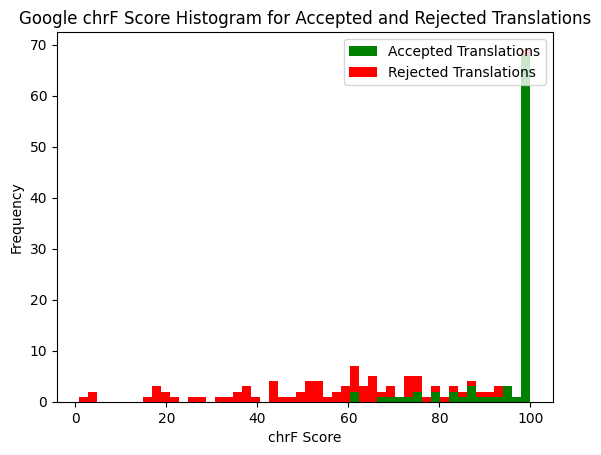

In [ ]:

plt.hist([accepted_translations_gt, rejected_translations_gt], bins=50, stacked=True, label=['Accepted Translations', 'Rejected Translations'], color=['green', 'red'])
plt.legend(loc='upper right')
plt.xlabel('chrF Score')
plt.ylabel('Frequency')
plt.title('Google chrF Score Histogram for Accepted and Rejected Translations')
plt.show()

Why did lower qualtiy translation from Google count as accurate translations?

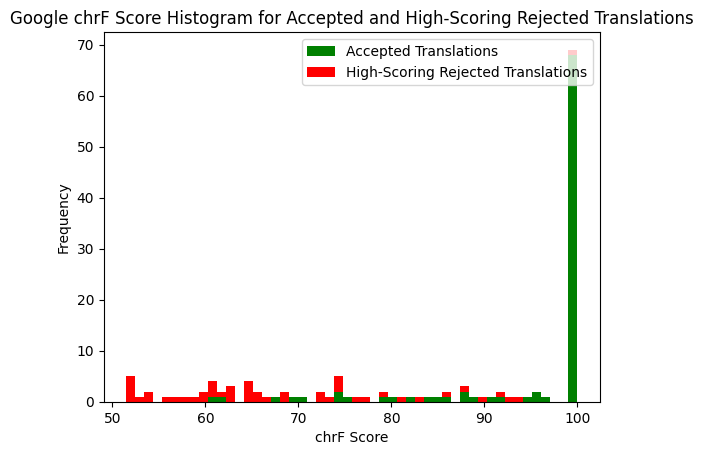

In [ ]:
high_score_threshold = 50

accepted_translations_gt = df_source[df_source['Correct_google']]['chrF_score_gt']
rejected_translations_gt = df_source[~df_source['Correct_google'] & (df_source['chrF_score_gt'] > high_score_threshold)]['chrF_score_gt']

plt.hist([accepted_translations_gt, rejected_translations_gt], bins=50, stacked=True, label=['Accepted Translations', 'High-Scoring Rejected Translations'], color=['green', 'red'])
plt.legend(loc='upper right')
plt.xlabel('chrF Score')
plt.ylabel('Frequency')
plt.title('Google chrF Score Histogram for Accepted and High-Scoring Rejected Translations')
plt.show()

In [ ]:

rejected_with_bleu_100_gt = df_source[(~df_source['Correct_google']) & (df_source['BLEU_score_gt'] == 100)]
rejected_with_chrf_100_gt = df_source[(~df_source['Correct_google']) & (df_source['chrF_score_gt'] == 100)]

print("Number of rejected translations with a Google BLEU score of 100:", len(rejected_with_bleu_100_gt))
print("Number of rejected translations with a Google chrF score of 100:", len(rejected_with_chrf_100_gt))

Number of rejected translations with a Google BLEU score of 100: 1
Number of rejected translations with a Google chrF score of 100: 1


In this case more Google translations were acceptable at lower measured distances from the ideal translation.


#### Examples of mistranslation

## Compare the Translations

#### Compare translate text length

#### Compare Word Frequency

#### Compare the bigrams


In [ ]:
# # Get the top 15 most frequent tokens for each translation
# Google_freq = pd.Series(' '.join(df_both_true['English_Google']).split()).value_counts()
# MT_freq = pd.Series(' '.join(df_both_true['Correct_opus-mt-tc-big-it']).split()).value_counts()
# GT_top = list(Google_freq.head(15).reset_index()['index'])
# MT_top = list(MT_freq.head(15).reset_index()['index'])

# # Get the unique tokens for each translation
# GT_unique = np.setdiff1d(GT_top, MT_top)
# MT_unique = np.setdiff1d(MT_top, GT_top)

# print("Unique tokens in Google translation:", GT_unique)
# print("Unique tokens in MT translation:", MT_unique)


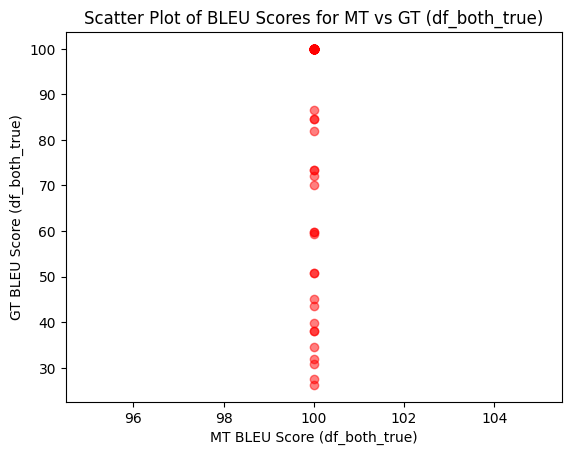

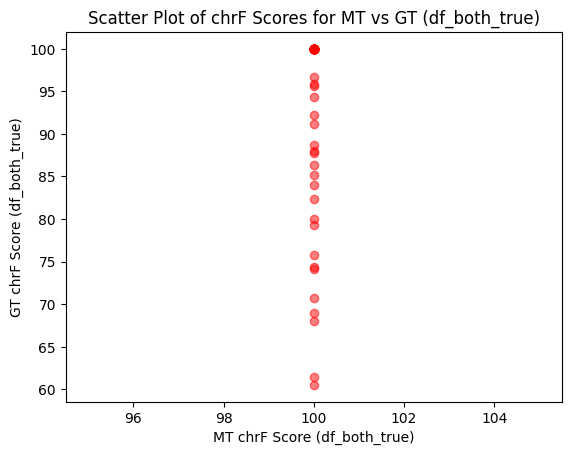

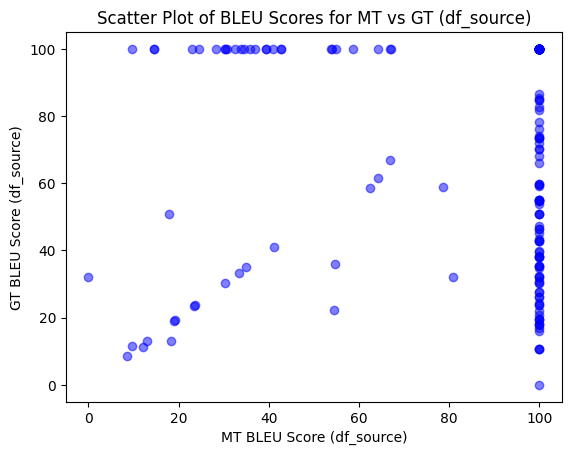

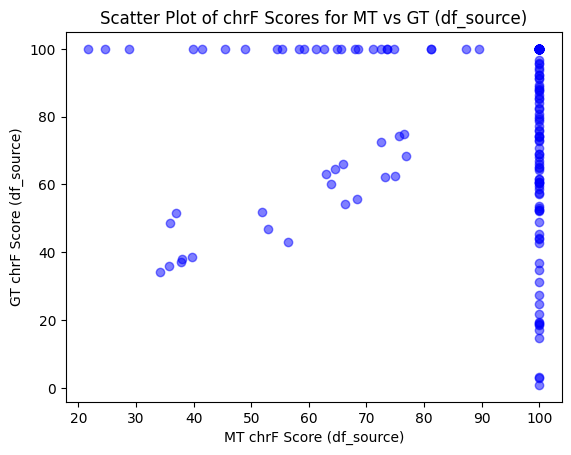

In [ ]:
# Scatter plot for df_both_true
plt.scatter(df_both_true['BLEU_score_mt'], df_both_true['BLEU_score_gt'], alpha=0.5, color='red')
plt.xlabel('MT BLEU Score (df_both_true)')
plt.ylabel('GT BLEU Score (df_both_true)')
plt.title('Scatter Plot of BLEU Scores for MT vs GT (df_both_true)')
plt.show()

plt.scatter(df_both_true['chrF_score_mt'], df_both_true['chrF_score_gt'], alpha=0.5, color='red')
plt.xlabel('MT chrF Score (df_both_true)')
plt.ylabel('GT chrF Score (df_both_true)')
plt.title('Scatter Plot of chrF Scores for MT vs GT (df_both_true)')
plt.show()

# Scatter plot for df_source
plt.scatter(df_source['BLEU_score_mt'], df_source['BLEU_score_gt'], alpha=0.5, color='blue')
plt.xlabel('MT BLEU Score (df_source)')
plt.ylabel('GT BLEU Score (df_source)')
plt.title('Scatter Plot of BLEU Scores for MT vs GT (df_source)')
plt.show()

plt.scatter(df_source['chrF_score_mt'], df_source['chrF_score_gt'], alpha=0.5, color='blue')
plt.xlabel('MT chrF Score (df_source)')
plt.ylabel('GT chrF Score (df_source)')
plt.title('Scatter Plot of chrF Scores for MT vs GT (df_source)')
plt.show()


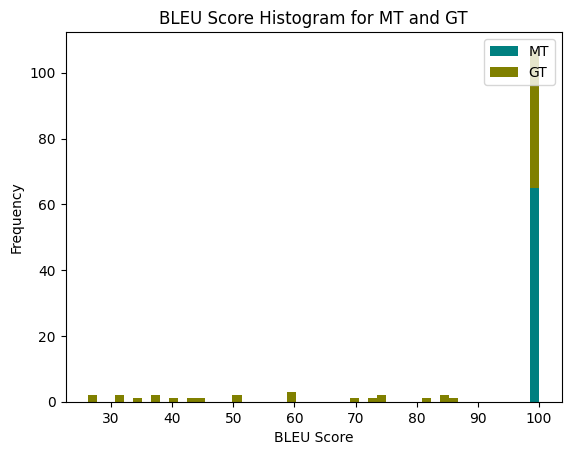

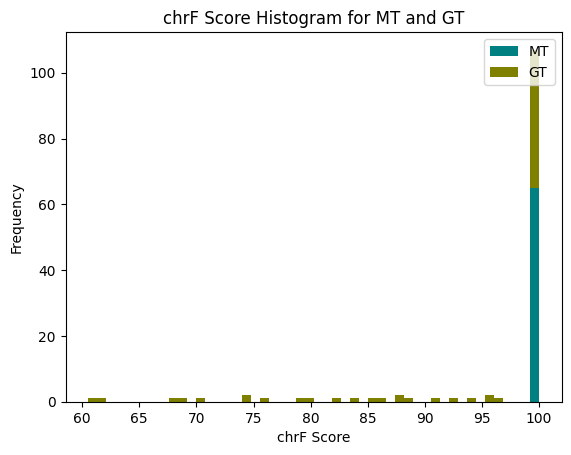

In [ ]:
plt.hist([df_both_true['BLEU_score_mt'], df_both_true['BLEU_score_gt']], bins=50, stacked=True, label=['MT', 'GT'], color=['teal', 'olive'])
plt.legend(loc='upper right')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Score Histogram for MT and GT')
plt.show()

plt.hist([df_both_true['chrF_score_mt'], df_both_true['chrF_score_gt']], bins=50, stacked=True, label=['MT', 'GT'], color=['teal', 'olive'])
plt.legend(loc='upper right')
plt.xlabel('chrF Score')
plt.ylabel('Frequency')
plt.title('chrF Score Histogram for MT and GT')
plt.show()


#### Conclusions

Higher the chrF and BLEU score the more likely it's a good tralnslatiion and we will run sentimemtn ananylsis on it.

The scoring system is valdating the humand system. HOwever, the Google Translate does lower quality but acceptable translations.

The conclusion data set is true_both. Where we will review sentiment analyss on only the good translations.

<!-- # Make sure to exclude bad translations and then possible compare for each translation.
# Will have to make sure that matching rows are compared.
# If we have sentences 3 wrong from marian and 3 in ops. We lose 6.
# When looking at the data set indepently we only lose the ones from that see. -->

# Sentiment Analysis

We need to evaluate the errors per sentiment analysis tool. The data gathered from each of these areas need to be combnined into a general tool that compares each sentiment tool and it's performance on our datsets Marian MT and Google Translate.

We'll look at the the errors on each of the datsets created by various entiment aalysis tools. We will review VADER, NLTK, TextBlog, Flair, and Pattern. These be measured against the gold/true standard sentiment as detemine by Dr. Carmela Scala our Italianm language exprt.

With each of the sentiment analisys tools we will also need to rever to top erros and detemine if there are any trends.


Potential errors:  
* Connotation,
* Equivocal. Either way but one choice.
* Slang or Colloquial usage


The classes are Negative, Neutral, Positive.

Sentiment count needed for the following information:
Human Translation, Negative, Neutral, Positive
Google Translate, Negative, Neutral, Positive
Marian MT, Negative, Neutral, Positive

Sentimemt score by sentence character length, and word count length.

Check the accuracy by translation model per sentiment tool.

Create word clouds for each sentiment types by translation model.

TODO: Consider using a polarity graph.


Sentiment error rates based on classifiend sentiment of neutral being -0.1 - 0.1.

Translations sentiment errors and examples

example table:

| Sentiment Label | Length| N ammount of other info | Total|
| ---- |:---|:- |:---|
| Negative | .|. | . |
| Neutral | .|. | . |
| Positive |. |. | . |


| Translation | Sentiment|  Length | Freq | Mean/Ave Senti | error count | error rate|
| ---- |:---|:- |:---|:---|:---|:---|
| Google Translate | .|. | . | . | . | . |
| Marian MT Translate | .|. | . | . | . | . |
| Human | .|. | . | . | . | . |

Confusion Matrices

Outlier statements with corresponding info


Summaries:
The summaries should show the same type of graph next to each other for visual analysis.

Outlier staements with corresponding info

| Correct Translation | True Sentiment | Len | Freq | Count | Translated Text | each sentiment | Error type | Conclusion |
| ---- |:---|:- |:---|:---|:---|:---|:---|:---|
| .|. | . | . | . | . | . | . | . | . |

One of these for each category erros.

Tally of errors overall.
translation, human, machine translations, sentime and combination of all erros.

Confusion matrix exclude the rows where the translation is wrong.  Check with Carmela on those translation. Can show with and without.



## VADER

For VADER we'll need the following:
* Accuracy
* Precision
* Recall
* f1 score

These all show up in the confusion matrix.



### Review and prepare the data for VADER.

In [ ]:
#review the data set fields:
df_both_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 61 to 35
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Number                           65 non-null     int64  
 1   Italian                          65 non-null     object 
 2   Original_sentiment               65 non-null     int64  
 3   English_opus-mt-tc-big-it-en     65 non-null     object 
 4   English_Google                   65 non-null     object 
 5   VADER_google_sa                  65 non-null     float64
 6   VADER_marian_sa                  65 non-null     float64
 7   NLTKPositive                     65 non-null     float64
 8   NLTKNegative                     65 non-null     float64
 9   NLTKNeutral                      65 non-null     float64
 10  NLTKSentiment                    65 non-null     float64
 11  NLTKPositive-G                   65 non-null     float64
 12  NLTKNegative-G         

In [ ]:
# label the vader sentiment categories
def label_sentiment(sentiment):
    if sentiment > 0:
        return 1.0
    elif sentiment >= -0.1 and sentiment <= 0.1:
        return 0
    else:
        return -1.0

df_both_true["vader_sentiment_gt_labeled"] = df_both_true['VADER_google_sa'].apply(label_sentiment)
df_both_true["vader_sentiment_mt_labeled"] = df_both_true['VADER_marian_sa'].apply(label_sentiment)

In [ ]:
# Double check the columns

print((df_both_true['VADER_google_sa'] == df_both_true['VADER_marian_sa']).all())


print(df_both_true[['VADER_google_sa', 'VADER_marian_sa']].describe())



False
       VADER_google_sa  VADER_marian_sa
count        65.000000        65.000000
mean          0.231591         0.231594
std           0.445173         0.445268
min          -0.700300        -0.700300
25%           0.000000         0.000000
50%           0.421500         0.421500
75%           0.611400         0.611400
max           0.925900         0.925900


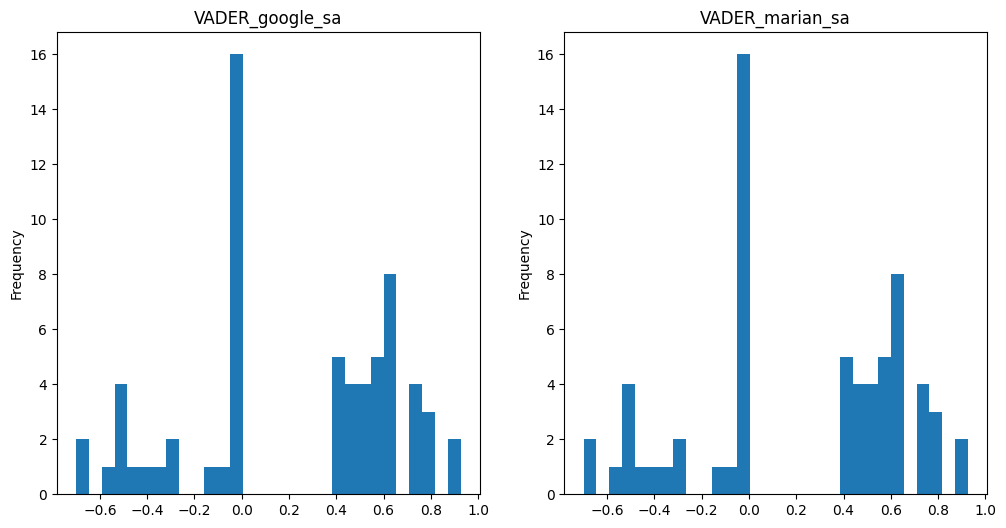

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_both_true['VADER_google_sa'].plot(kind='hist', bins=30, title='VADER_google_sa')

plt.subplot(1, 2, 2)
df_both_true['VADER_marian_sa'].plot(kind='hist', bins=30, title='VADER_marian_sa')

plt.show()


In [ ]:
confusion_matrix_compare = pd.crosstab(df_both_true['vader_sentiment_gt_labeled'], df_both_true['vader_sentiment_mt_labeled'], margins=True)
print(confusion_matrix_compare)


vader_sentiment_mt_labeled  -1.0  0.0  1.0  All
vader_sentiment_gt_labeled                     
-1.0                          13    0    0   13
0.0                            0   17    0   17
1.0                            0    0   35   35
All                           13   17   35   65


Set up the labels and variables for working with VADER

In [ ]:
print(df_both_true[['VADER_google_sa', 'VADER_marian_sa']].describe())



       VADER_google_sa  VADER_marian_sa
count        65.000000        65.000000
mean          0.231591         0.231594
std           0.445173         0.445268
min          -0.700300        -0.700300
25%           0.000000         0.000000
50%           0.421500         0.421500
75%           0.611400         0.611400
max           0.925900         0.925900


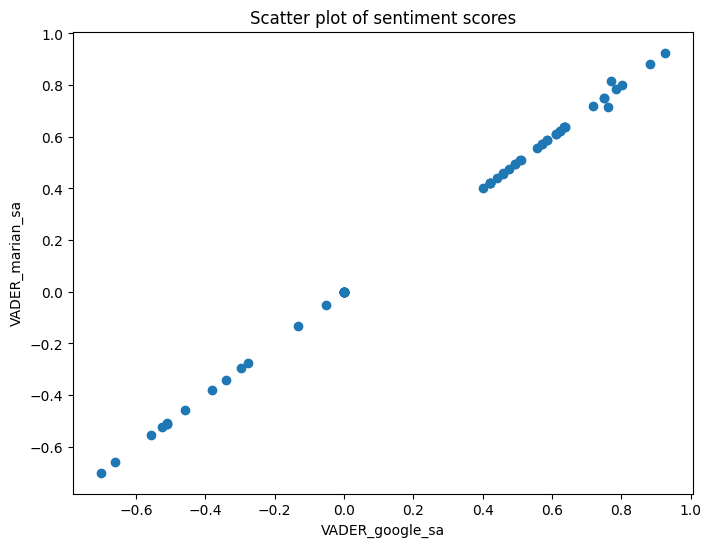

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_both_true['VADER_google_sa'], df_both_true['VADER_marian_sa'])
plt.xlabel('VADER_google_sa')
plt.ylabel('VADER_marian_sa')
plt.title('Scatter plot of sentiment scores')
plt.show()


In [ ]:
# Convert the sentiment labels to a float value 1.0. 0.0, or -1.0
def convert_sentiment(sentiment):
    if sentiment == 'Positive':
        return 1.0
    elif sentiment == 'Neutral':
        return 0.0
    elif sentiment == 'Negative':
        return -1.0

df_both_true['true_sentiment_value'] = df_both_true['true_sentiment'].apply(convert_sentiment)

print(f"Original/True: { df_both_true['true_sentiment'].unique()}")
print(f"ALL { df_both_true['true_sentiment_value'].unique()}")
print(f"GT { df_both_true['vader_sentiment_gt_labeled'].unique()}")
print(f"MT { df_both_true['vader_sentiment_mt_labeled'].unique()}")


Original/True: ['Positive' 'Neutral' 'Negative']
ALL [ 1.  0. -1.]
GT [ 1.  0. -1.]
MT [ 1.  0. -1.]


In [ ]:
# Convert sentiment values from integer to float
# df_both_true['vader_sentiment_gt_labeled'] = df_both_true['vader_sentiment_gt_labeled'].astype(float)
# df_both_true['vader_sentiment_mt_labeled'] = df_both_true['vader_sentiment_mt_labeled'].astype(float)

# Calculate various metrics for each sentiment category in MT and GT translations
summary_metrics = {}

for translation_type in ['gt', 'mt']:
    translation_metrics = {}
    for sentiment in [-1.0, 0.0, 1.0]:
        sentiment_data = df_both_true[df_both_true[f'vader_sentiment_{translation_type}_labeled'] == sentiment]
        sentiment_metrics = {
            'mean': sentiment_data['len'].mean(),  # average sentence length
            'sentiment_ratio': len(sentiment_data) / len(df_both_true),  # proportion of this sentiment category
            'word_count': sentiment_data['word_count'].sum(),  # total word count
            'word_frequency': sentiment_data['word_count'].sum() / len(sentiment_data)  # average word count per sentence
        }
        translation_metrics[sentiment] = sentiment_metrics
    summary_metrics[translation_type] = translation_metrics



In [ ]:
# Convert the summary_metrics dictionary into a DataFrame
summary_df = pd.DataFrame()

for translation_type, translation_metrics in summary_metrics.items():
    for sentiment, sentiment_metrics in translation_metrics.items():
        sentiment_metrics['Translation'] = translation_type
        sentiment_metrics['Sentiment'] = sentiment
        summary_df = summary_df.append(sentiment_metrics, ignore_index=True)

# Change the Sentiment column from float to category
summary_df['Sentiment'] = summary_df['Sentiment'].replace({-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'})

# Set 'Translation' and 'Sentiment' as multi-index
summary_df.set_index(['Translation', 'Sentiment'], inplace=True)

# Display the DataFrame
print(summary_df)


                            mean  sentiment_ratio  word_count  word_frequency
Translation Sentiment                                                        
gt          Negative   23.076923         0.200000          54        4.153846
            Neutral    37.411765         0.261538         109        6.411765
            Positive   32.371429         0.538462         197        5.628571
mt          Negative   23.076923         0.200000          54        4.153846
            Neutral    37.411765         0.261538         109        6.411765
            Positive   32.371429         0.538462         197        5.628571


In [ ]:
# Need to check the accuracy of this code
# Select 10 random rows from the DataFrame
sample_rows = df_both_true.sample(10)

# Print out the true sentiment value, VADER sentiment value for Google translations, and VADER sentiment value for MT translations
print(sample_rows[['true_sentiment_value', 'VADER_google_sa', 'VADER_marian_sa']])


# Filter the DataFrame to get rows where VADER scores are different
df_vader_diff = df_both_true[df_both_true['VADER_google_sa'] != df_both_true['VADER_marian_sa']]

# Count the number of rows with different VADER scores
count_diff = len(df_vader_diff)
print(f'Number of rows with different VADER scores: {count_diff}')

# Display the rows with different VADER scores
df_vader_diff[['VADER_google_sa', 'VADER_marian_sa']]

for index, row in df_vader_diff.iterrows():
    print(f"Row index: {index}")
    print("True Sentiment:", row['true_sentiment'])

    print("Google Translation:")
    print(row['English_Google'])
    print("VADER Sentiment Score (Google):", row['VADER_google_sa'])

    print("Marian Translation:")
    print(row['English_opus-mt-tc-big-it-en'])
    print("VADER Sentiment Score (Marian):", row['VADER_marian_sa'])

    print("-----")



print("since the df_both_true has nearly the same number of true translations the percentage accurcy would be the same.")
google_vader_acc = len(df_both_true[df_both_true['true_sentiment_value'] == df_both_true['VADER_google_sa']]) / len(df_both_true) * 100
print('VADER accuracy rate on Google Translation: {0:.2f}%'.format(google_vader_acc))

mt_vader_acc = len(df_both_true[df_both_true['true_sentiment_value'] == df_both_true['VADER_marian_sa']]) / len(df_both_true) * 100
print('VADER accuracy rate on MT Translation: {0:.2f}%'.format(mt_vader_acc))



     true_sentiment_value  VADER_google_sa  VADER_marian_sa
94                   -1.0          -0.5106          -0.5106
49                    1.0           0.6114           0.6114
12                    1.0           0.4215           0.4215
50                    1.0           0.6360           0.6360
142                   0.0           0.0000           0.0000
138                   0.0           0.4767           0.4767
66                   -1.0          -0.4574          -0.4574
107                  -1.0           0.4926           0.4926
154                   0.0           0.0000           0.0000
141                   0.0          -0.0516          -0.0516
Number of rows with different VADER scores: 2
Row index: 62
True Sentiment: Positive
Google Translation:
Yesterday I visited a very interesting art museum and I liked it very much, I want to go back!
VADER Sentiment Score (Google): 0.7693
Marian Translation:
Yesterday I visited a very interesting art museum and I loved it, I want to go ba

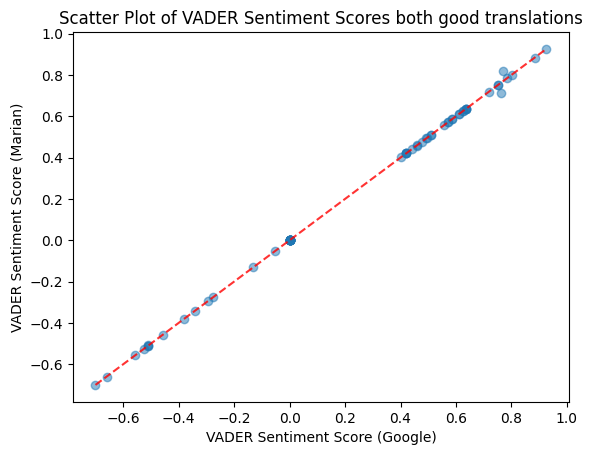

In [ ]:

plt.scatter(df_both_true['VADER_google_sa'], df_both_true['VADER_marian_sa'], alpha=0.5)
plt.xlabel('VADER Sentiment Score (Google)')
plt.ylabel('VADER Sentiment Score (Marian)')
plt.title('Scatter Plot of VADER Sentiment Scores both good translations')

# Add a diagonal line
limits = [min(df_both_true['VADER_google_sa'].min(), df_both_true['VADER_marian_sa'].min()),
          max(df_both_true['VADER_google_sa'].max(), df_both_true['VADER_marian_sa'].max())]
plt.plot(limits, limits, color='red', linestyle='--', alpha=0.8)

plt.show()


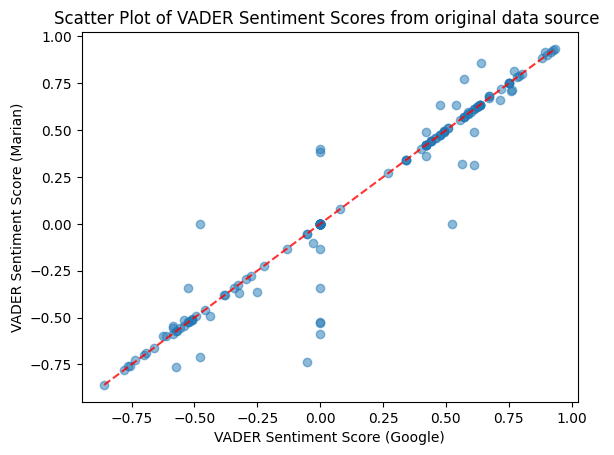

In [ ]:
# Check against the original data set
plt.scatter(df_source['VADER_google_sa'], df_source['VADER_marian_sa'], alpha=0.5)
plt.xlabel('VADER Sentiment Score (Google)')
plt.ylabel('VADER Sentiment Score (Marian)')
plt.title('Scatter Plot of VADER Sentiment Scores from original data source ')

# Add a diagonal line
limits = [min(df_source['VADER_google_sa'].min(), df_source['VADER_marian_sa'].min()),
          max(df_source['VADER_google_sa'].max(), df_source['VADER_marian_sa'].max())]
plt.plot(limits, limits, color='red', linestyle='--', alpha=0.8)

plt.show()



### VADER Google Translate


In [ ]:
google_vader_counts = df_both_true['VADER_google_sa'].value_counts().head(10)
print(google_vader_counts)


 0.0000    16
 0.4215     3
 0.5719     2
 0.6369     2
-0.5106     2
 0.5859     2
 0.6239     2
 0.6114     2
 0.6360     2
 0.5093     1
Name: VADER_google_sa, dtype: int64


The labeling with sentiment is complete.

In [ ]:
# group by the labeled vader_sentiment and count
df_grouped = df_both_true.groupby('vader_sentiment_gt_labeled')
df_both_true['vader_sentiment_gt_labeled'].value_counts()



 1.0    35
 0.0    17
-1.0    13
Name: vader_sentiment_gt_labeled, dtype: int64

#### Confusion Matrices

##### Create a confusion matrix
This will show the correct and missclasification performance

In [ ]:
# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df_both_true['true_sentiment'], df_both_true['vader_sentiment_gt_labeled'], margins=True)
print(confusion_matrix)

vader_sentiment_gt_labeled  -1.0  0.0  1.0  All
true_sentiment                                 
Negative                      12    2    1   15
Neutral                        1   15    2   18
Positive                       0    0   32   32
All                           13   17   35   65


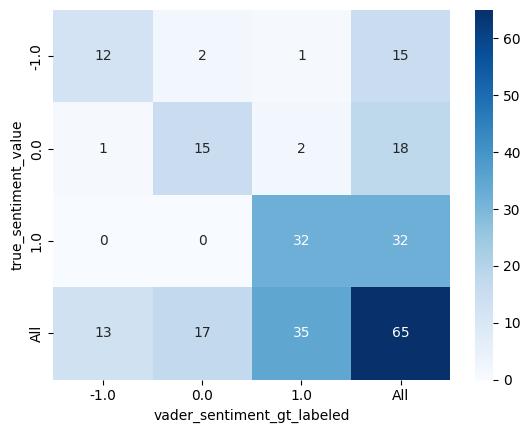

In [ ]:


# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df_both_true['true_sentiment_value'], df_both_true['vader_sentiment_gt_labeled'], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.show()


#### Word freq and sentence length that

vader_sentiment_gt_labeled
-1.0    Axes(0.125,0.11;0.775x0.77)
 0.0    Axes(0.125,0.11;0.775x0.77)
 1.0    Axes(0.125,0.11;0.775x0.77)
Name: word_count, dtype: object

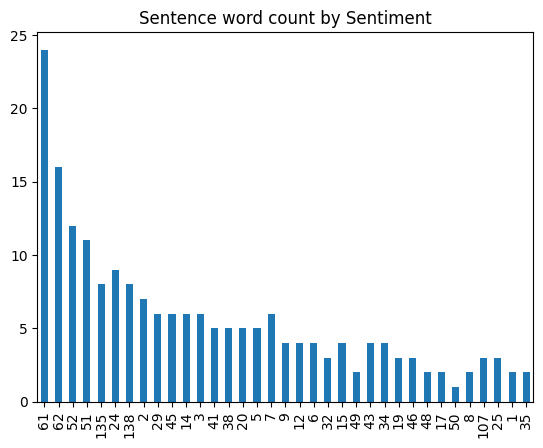

In [ ]:
df_grouped["word_count"].plot(kind="bar", title="Sentence word count by Sentiment")


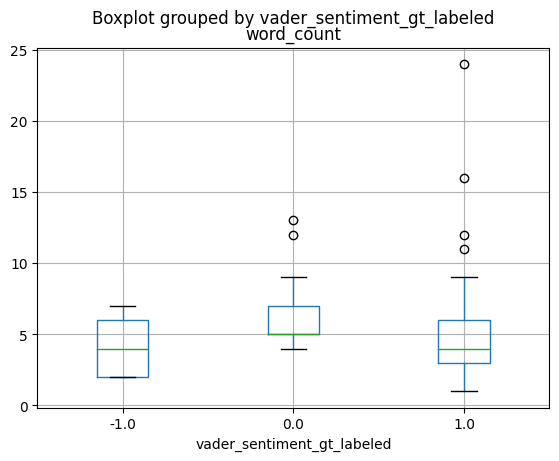

In [ ]:
# Create a box plot
ax = df_both_true.boxplot(column="word_count", by='vader_sentiment_gt_labeled')

# Show the plot
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 61 to 35
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VADER_google_sa  65 non-null     float64
 1   true_sentiment   65 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


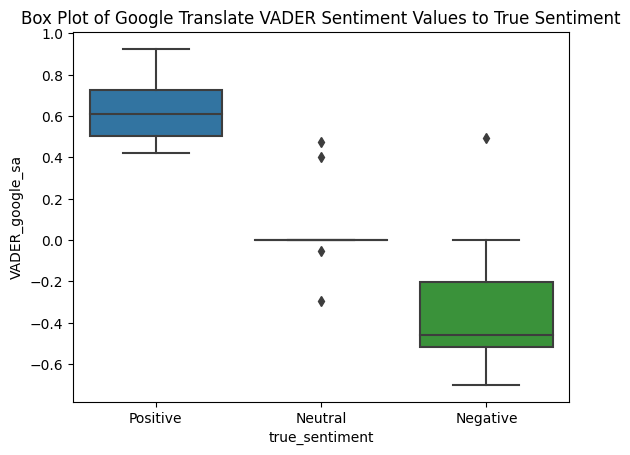

In [ ]:
import seaborn as sns


# Create a data frame that contains the 'sentiment' and 'sent_g' values for each row in the original data frame
sentiment_df = df_both_true[['VADER_google_sa', 'true_sentiment']].copy()
sentiment_df.info()

# Display a box plot of the sentiment values, grouped by the 'sent_g' values
sns.boxplot(x='true_sentiment', y='VADER_google_sa', data=sentiment_df)

# Add a title
plt.title('Box Plot of Google Translate VADER Sentiment Values to True Sentiment')

# Show the plot
plt.show()

In [ ]:
def find_outliers(data):
    Q1 = data.quantile(0.20)
    Q3 = data.quantile(0.80)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]
    return outliers.index

# Loop through unique true_sentiment values
for sentiment in df_both_true['true_sentiment'].unique():
    sentiment_data = df_both_true[df_both_true['true_sentiment'] == sentiment]['VADER_google_sa']
    outlier_indices = find_outliers(sentiment_data)

    print(f"Outliers for {sentiment}:")
    for i in outlier_indices:
        print('Sentence:', df_both_true.loc[i]['Italian'])
        print('Google Translation:', df_both_true.loc[i]['English_Google'])
        print('True Sentiment:', df_both_true.loc[i]['true_sentiment'])
        print('True Sentiment Value:', df_both_true.loc[i]['true_sentiment_value'])
        print('VADER Sentiment:', df_both_true.loc[i]['VADER_google_sa'])
        print('----------------------')


Outliers for Positive:
Outliers for Neutral:
Sentence: La musica american attrae sempre molti giovani italiani
Google Translation: American music always attracts many young Italians
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment: 0.4019
----------------------
Sentence: I miei amici sono venuti a farmi visita
Google Translation: My friends came to visit me
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment: 0.4767
----------------------
Sentence: Non ho preferenze su cosa fare stasera
Google Translation: I have no preferences on what to do tonight
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment: -0.296
----------------------
Sentence: Domani partiamo per andare in Italia
Google Translation: Tomorrow we leave to go to Italy
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment: -0.0516
----------------------
Outliers for Negative:


In [ ]:
df_both_true.loc[:, ['vader_sentiment_gt_labeled', 'VADER_google_sa']].head()


,vader_sentiment_gt_labeled,VADER_google_sa
61,1.0,0.9259
62,1.0,0.7693
52,1.0,0.7501
133,0.0,0.0000
121,0.0,0.0000


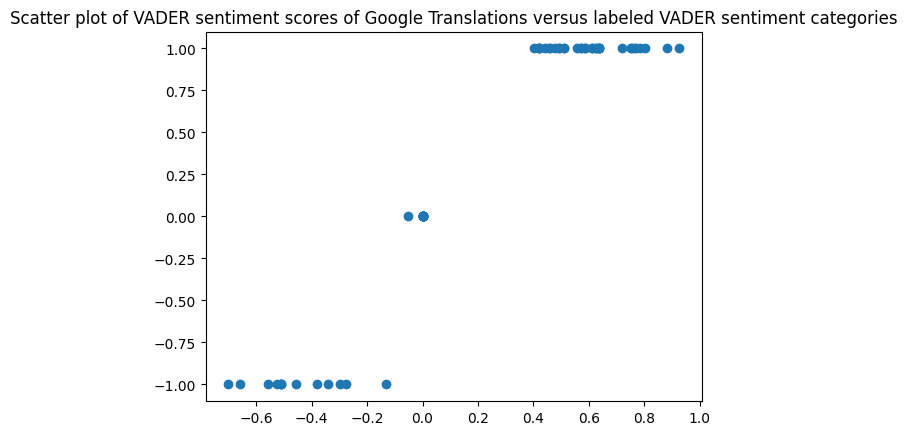

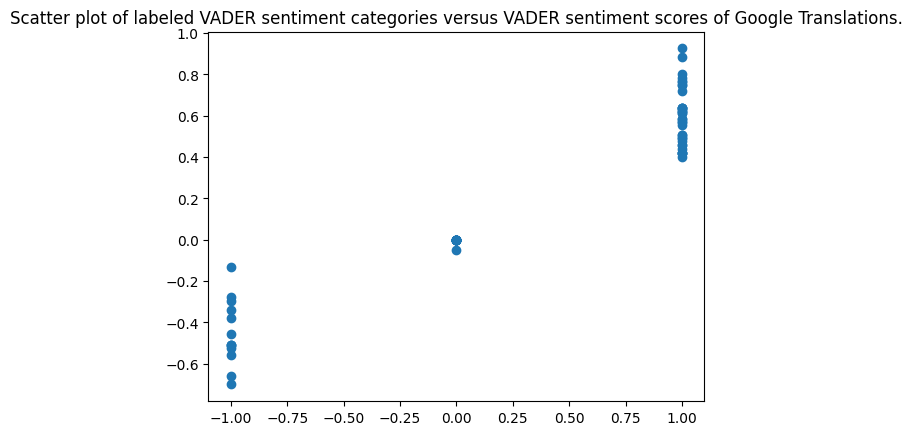

In [ ]:
# create a scatter plot of the sentiment values, grouped by label
plt.scatter(df_both_true['VADER_google_sa'], df_both_true["vader_sentiment_gt_labeled"])
plt.title("Scatter plot of VADER sentiment scores of Google Translations versus labeled VADER sentiment categories")
plt.show()

plt.scatter(df_both_true["vader_sentiment_gt_labeled"], df_both_true['VADER_google_sa'])
plt.title("Scatter plot of labeled VADER sentiment categories versus VADER sentiment scores of Google Translations.")
plt.show()

<Axes: title={'center': 'Sentence Counts by Sentiment'}, ylabel='vader_sentiment_mt_labeled'>

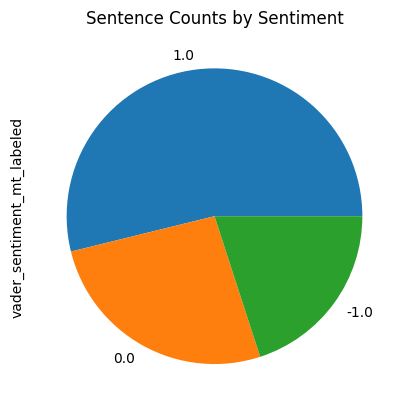

In [ ]:
sentence_counts = df_both_true["vader_sentiment_mt_labeled"].value_counts()

sentence_counts.plot(kind="pie", title="Sentence Counts by Sentiment")
# PiE chart of what was correctly translated
# Postivie sentiment with greater accuracy


### VADER Marian MT

#### Review and prepare the data

In [ ]:
# Use VADER_marian_sa
# Calculate VADER sentiment for MT translations
#df_both_true["vader_sentiment_mt_label"] = df_both_true['VADER_marian_sa'].apply(label_sentiment)



#### Calculate and show the confusion matrix

vader_sentiment_mt_labeled  -1.0  0.0  1.0  All
true_sentiment                                 
Negative                      12    2    1   15
Neutral                        1   15    2   18
Positive                       0    0   32   32
All                           13   17   35   65


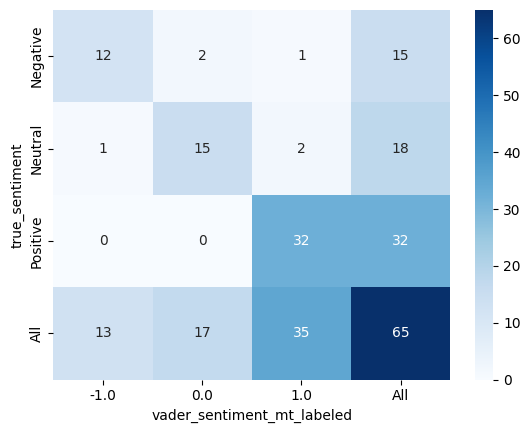

In [ ]:

# Calculate the confusion matrix for MT translations
confusion_matrix_mt = pd.crosstab(df_both_true['true_sentiment'], df_both_true["vader_sentiment_mt_labeled"], margins=True)
print(confusion_matrix_mt)

# Display the confusion matrix as a heat map for MT translations
sns.heatmap(confusion_matrix_mt, annot=True, cmap='Blues')
plt.show()


In [ ]:
# Count true_sentiment for each vader_sentiment_gt_labeled
gt_label_counts = df_both_true.groupby('vader_sentiment_gt_labeled')['true_sentiment'].size()

# Count true_sentiment for each vader_sentiment_mt_label
mt_label_counts = df_both_true.groupby('vader_sentiment_mt_labeled')['true_sentiment'].size()

# Calculate the difference
difference = gt_label_counts.subtract(mt_label_counts, fill_value=0)

overall_difference = difference.sum()



In [ ]:
print("Counts for vader_sentiment_gt_labeled:")
print(gt_label_counts)

print("\nCounts for vader_sentiment_mt_label:")
print(mt_label_counts)

print("\nDifference in counts:")
print(difference)

print("\nOverall difference:", overall_difference)


Counts for vader_sentiment_gt_labeled:
vader_sentiment_gt_labeled
-1.0    13
 0.0    17
 1.0    35
Name: true_sentiment, dtype: int64

Counts for vader_sentiment_mt_label:
vader_sentiment_mt_labeled
-1.0    13
 0.0    17
 1.0    35
Name: true_sentiment, dtype: int64

Difference in counts:
vader_sentiment_gt_labeled
-1.0    0
 0.0    0
 1.0    0
Name: true_sentiment, dtype: int64

Overall difference: 0


In [ ]:
print((df_both_true['vader_sentiment_gt_labeled'] == df_both_true['vader_sentiment_mt_labeled']).all())
print((df_both_true['true_sentiment_value'] == df_both_true['true_sentiment']).all())


True
False


Box plot of the sentiment values, grouped by the 'true_sentiment' values for MT translations


In [ ]:

# Box plot of the sentiment values, grouped by the 'true_sentiment' values for MT translations
sns.boxplot(x='true_sentiment', y='vader_sentiment_mt_label', data=df_both_true)
plt.title('Box Plot of Sentiment Values for MT Translations')
plt.show()



Scatter plots

In [ ]:
# Scatter plot of VADER sentiment scores of MT Translations versus labeled VADER sentiment categories
plt.scatter(df_both_true['VADER_marian_sa'], df_both_true["vader_sentiment_mt_label"])
plt.title("Scatter plot of VADER sentiment scores of MT Translations versus labeled VADER sentiment categories")
plt.show()

# Scatter plot of labeled VADER sentiment categories versus VADER sentiment scores of MT Translations
plt.scatter(df_both_true["vader_sentiment_mt_label"], df_both_true['VADER_marian_sa'])
plt.title("Scatter plot of labeled VADER sentiment categories versus VADER sentiment scores of MT Translations.")
plt.show()


#### Find and show the outliers

Outliers for Positive:
Outliers for Neutral:
Sentence: La musica american attrae sempre molti giovani italiani
Marian MT Translation: American music always attracts many young Italians
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment (MT): 0.4019
----------------------
Sentence: I miei amici sono venuti a farmi visita
Marian MT Translation: My friends came to visit me
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment (MT): 0.4767
----------------------
Sentence: Non ho preferenze su cosa fare stasera
Marian MT Translation: I have no preference on what to do tonight
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment (MT): -0.296
----------------------
Outliers for Negative:
Sentence: Sei un essere abominevole.
Marian MT Translation: You are an abominable being.
True Sentiment: Negative
True Sentiment Value: -1.0
VADER Sentiment (MT): 0.0
----------------------
Sentence: Disapprovo la tua scelta!
Marian MT Translation: I disapprove of your 

<Axes: title={'center': 'Percent sentences by Sentiment for MT Translations'}, ylabel='vader_sentiment_mt_labeled'>

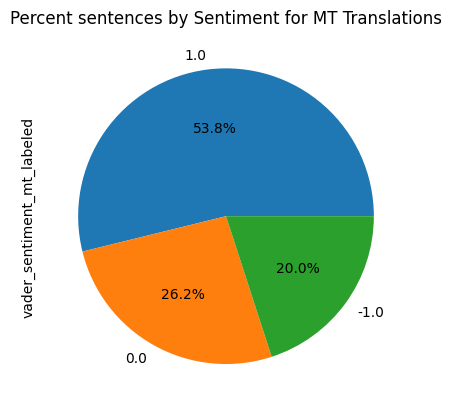

In [ ]:

# Loop through unique true_sentiment values for MT translations
for sentiment in df_both_true['true_sentiment'].unique():
    sentiment_data = df_both_true[df_both_true['true_sentiment'] == sentiment]['vader_sentiment_mt_labeled']
    outlier_indices = find_outliers(sentiment_data)

    print(f"Outliers for {sentiment}:")
    for i in outlier_indices:
        print('Sentence:', df_both_true.loc[i]['Italian'])
        print('Marian MT Translation:', df_both_true.loc[i]['English_opus-mt-tc-big-it-en'])
        print('True Sentiment:', df_both_true.loc[i]['true_sentiment'])
        print('True Sentiment Value:', df_both_true.loc[i]['true_sentiment_value'])
        print('VADER Sentiment (MT):', df_both_true.loc[i]['VADER_marian_sa'])
        print('----------------------')

# Pie chart for sentence counts by sentiment for MT translations
sentence_counts_mt = df_both_true["vader_sentiment_mt_labeled"].value_counts()
sentence_counts_mt.plot(kind="pie", title="Percent sentences by Sentiment for MT Translations",autopct='%1.1f%%')

Outliers for Positive:
Outliers for Neutral:
Sentence: La musica american attrae sempre molti giovani italiani
Marian MT Translation: American music always attracts many young Italians
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment (MT): 0.4019
----------------------
Sentence: I miei amici sono venuti a farmi visita
Marian MT Translation: My friends came to visit me
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment (MT): 0.4767
----------------------
Sentence: Non ho preferenze su cosa fare stasera
Marian MT Translation: I have no preference on what to do tonight
True Sentiment: Neutral
True Sentiment Value: 0.0
VADER Sentiment (MT): -0.296
----------------------
Outliers for Negative:
Sentence: Sei un essere abominevole.
Marian MT Translation: You are an abominable being.
True Sentiment: Negative
True Sentiment Value: -1.0
VADER Sentiment (MT): 0.0
----------------------
Sentence: Disapprovo la tua scelta!
Marian MT Translation: I disapprove of your 

<Axes: title={'center': 'Percent sentences by Sentiment for Google Translate Translations'}, ylabel='vader_sentiment_gt_labeled'>

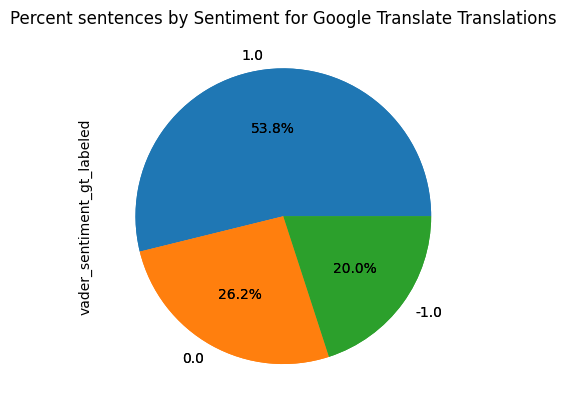

In [ ]:
# Loop through unique true_sentiment values for MT translations
for sentiment in df_both_true['true_sentiment'].unique():
    sentiment_data = df_both_true[df_both_true['true_sentiment'] == sentiment]['vader_sentiment_mt_labeled']
    outlier_indices = find_outliers(sentiment_data)

    print(f"Outliers for {sentiment}:")
    for i in outlier_indices:
        print('Sentence:', df_both_true.loc[i]['Italian'])
        print('Marian MT Translation:', df_both_true.loc[i]['English_opus-mt-tc-big-it-en'])
        print('True Sentiment:', df_both_true.loc[i]['true_sentiment'])
        print('True Sentiment Value:', df_both_true.loc[i]['true_sentiment_value'])
        print('VADER Sentiment (MT):', df_both_true.loc[i]['VADER_marian_sa'])
        print('----------------------')

# Pie chart for sentence counts by sentiment for MT translations
sentence_counts_mt = df_both_true["vader_sentiment_mt_labeled"].value_counts()
sentence_counts_mt.plot(kind="pie", title="Sentence Counts by Sentiment for MT Translations", autopct='%1.1f%%')

# Loop through unique true_sentiment values for Google Translate translations
for sentiment in df_both_true['true_sentiment'].unique():
    sentiment_data = df_both_true[df_both_true['true_sentiment'] == sentiment]['vader_sentiment_gt_labeled']
    outlier_indices = find_outliers(sentiment_data)

    print(f"Outliers for {sentiment}:")
    for i in outlier_indices:
        print('Sentence:', df_both_true.loc[i]['Italian'])
        print('Google Translate Translation:', df_both_true.loc[i]['English_Google'])
        print('True Sentiment:', df_both_true.loc[i]['true_sentiment'])
        print('True Sentiment Value:', df_both_true.loc[i]['true_sentiment_value'])
        print('VADER Sentiment (GT):', df_both_true.loc[i]['VADER_google_sa'])
        print('----------------------')

# Pie chart for sentence counts by sentiment for Google Translate translations
sentence_counts_gt = df_both_true["vader_sentiment_gt_labeled"].value_counts()
sentence_counts_gt.plot(kind="pie", title="Percent sentences by Sentiment for Google Translate Translations", autopct='%1.1f%%')


Put these two pie charts next to each other to show one vs the other that the positive was translated better.


### Summary


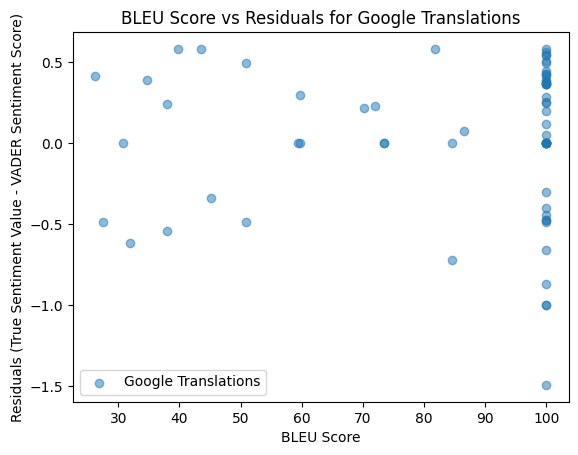

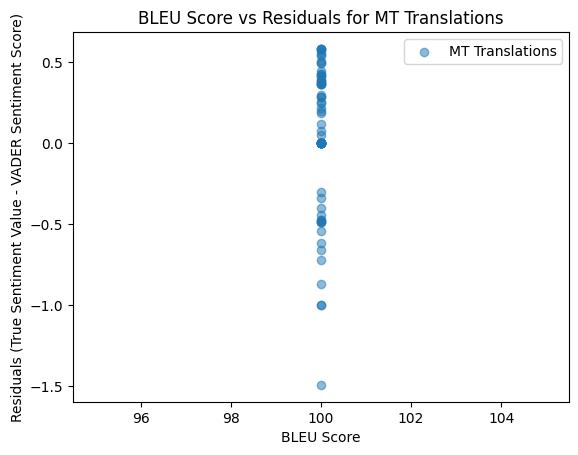

In [ ]:
# Calculate the residuals/differences
df_both_true["residual_google"] = df_both_true["true_sentiment_value"] - df_both_true['VADER_google_sa']
df_both_true["residual_mt"] = df_both_true["true_sentiment_value"] - df_both_true['VADER_marian_sa']

# Scatter plot for Google Translations
plt.scatter(df_both_true["BLEU_score_gt"], df_both_true["residual_google"], label="Google Translations", alpha=0.5)
plt.xlabel("BLEU Score")
plt.ylabel("Residuals (True Sentiment Value - VADER Sentiment Score)")
plt.title("BLEU Score vs Residuals for Google Translations")
plt.legend()
plt.show()

# Scatter plot for MT Translations
plt.scatter(df_both_true["BLEU_score_mt"], df_both_true["residual_mt"], label="MT Translations", alpha=0.5)
plt.xlabel("BLEU Score")
plt.ylabel("Residuals (True Sentiment Value - VADER Sentiment Score)")
plt.title("BLEU Score vs Residuals for MT Translations")
plt.legend()
plt.show()


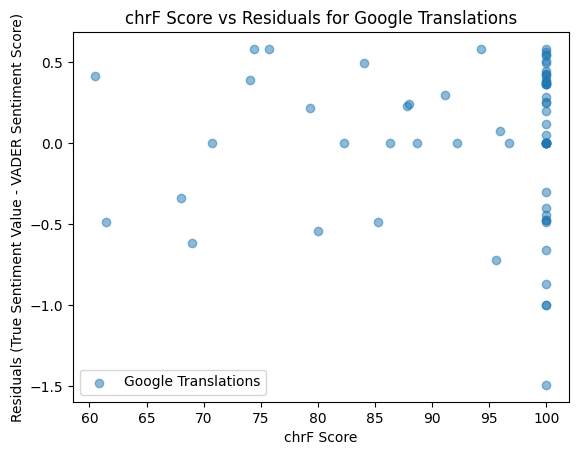

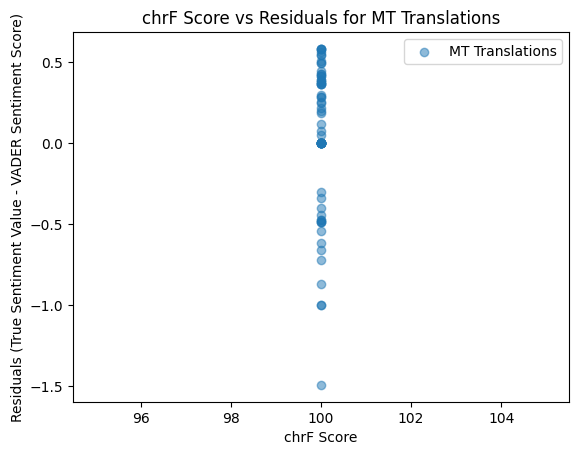

In [ ]:
# Calculate the residuals/differences
df_both_true["residual_google"] = df_both_true["true_sentiment_value"] - df_both_true['VADER_google_sa']
df_both_true["residual_mt"] = df_both_true["true_sentiment_value"] - df_both_true['VADER_marian_sa']

# Scatter plot for Google Translations
plt.scatter(df_both_true["chrF_score_gt"], df_both_true["residual_google"], label="Google Translations", alpha=0.5)
plt.xlabel("chrF Score")
plt.ylabel("Residuals (True Sentiment Value - VADER Sentiment Score)")
plt.title("chrF Score vs Residuals for Google Translations")
plt.legend()
plt.show()

# Scatter plot for MT Translations
plt.scatter(df_both_true["chrF_score_mt"], df_both_true["residual_mt"], label="MT Translations", alpha=0.5)
plt.xlabel("chrF Score")
plt.ylabel("Residuals (True Sentiment Value - VADER Sentiment Score)")
plt.title("chrF Score vs Residuals for MT Translations")
plt.legend()
plt.show()


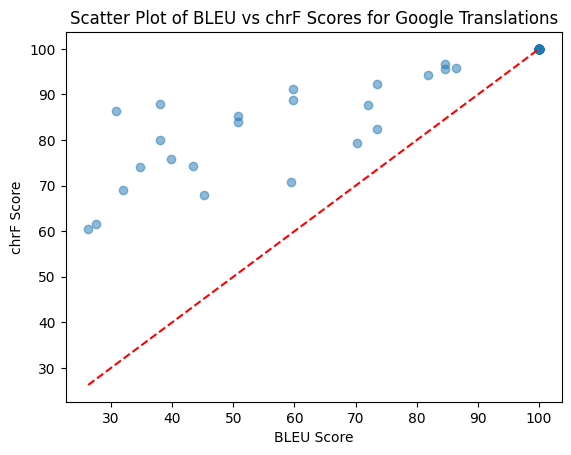

In [ ]:
# Create a scatter plot comparing BLEU and chrF scores
plt.scatter(df_both_true["BLEU_score_gt"], df_both_true["chrF_score_gt"], alpha=0.5)
plt.xlabel("BLEU Score")
plt.ylabel("chrF Score")
plt.title("Scatter Plot of BLEU vs chrF Scores for Google Translations")

# Add a diagonal line to visualize the correlation
limits = [
    min(df_both_true["BLEU_score_gt"].min(), df_both_true["chrF_score_gt"].min()),
    max(df_both_true["BLEU_score_gt"].max(), df_both_true["chrF_score_gt"].max())
]
plt.plot(limits, limits, linestyle="--", color="red")

plt.show()


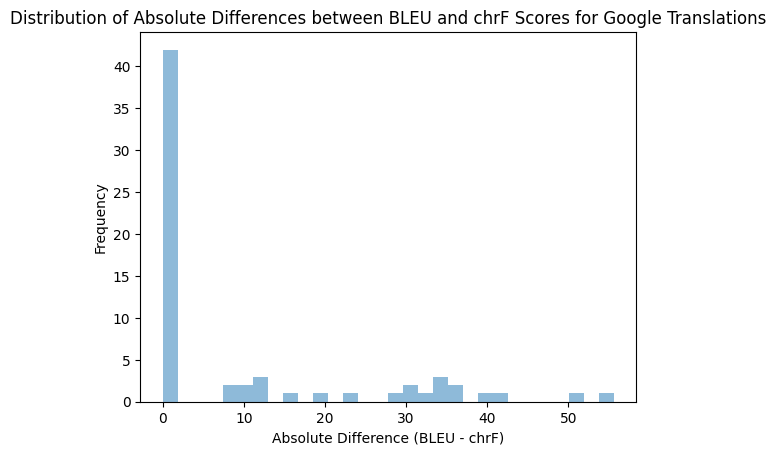

In [ ]:
# Calculate the absolute difference between BLEU and chrF scores
df_both_true["abs_diff_gt"] = abs(df_both_true["BLEU_score_gt"] - df_both_true["chrF_score_gt"])

# Create a histogram to visualize the distribution of the absolute differences
plt.hist(df_both_true["abs_diff_gt"], bins=30, alpha=0.5)
plt.xlabel("Absolute Difference (BLEU - chrF)")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Differences between BLEU and chrF Scores for Google Translations")
plt.show()


In [ ]:
df_both_true['score_difference'] = df_both_true['chrF_score_gt'] - df_both_true['BLEU_score_gt']


In [ ]:
mean_difference = df_both_true['score_difference'].mean()
std_difference = df_both_true['score_difference'].std()

print(f"Mean difference: {mean_difference}")
print(f"Standard deviation of differences: {std_difference}")


Mean difference: 9.519692307692308
Standard deviation of differences: 15.313987985787573


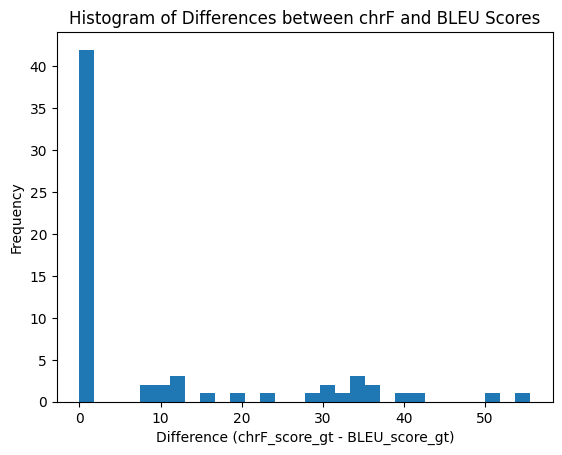

In [ ]:
plt.hist(df_both_true['score_difference'], bins=30)
plt.xlabel('Difference (chrF_score_gt - BLEU_score_gt)')
plt.ylabel('Frequency')
plt.title('Histogram of Differences between chrF and BLEU Scores')
plt.show()


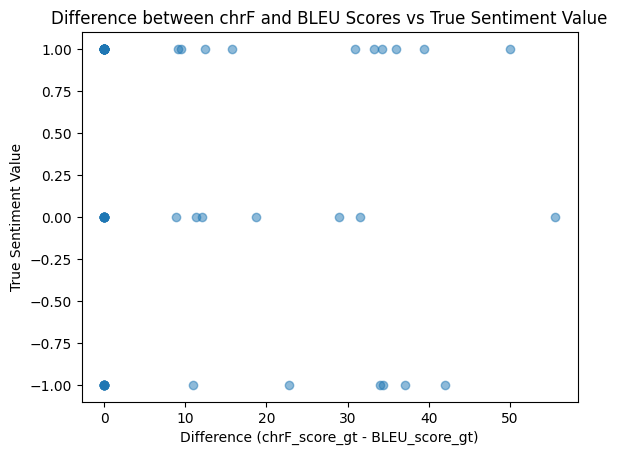

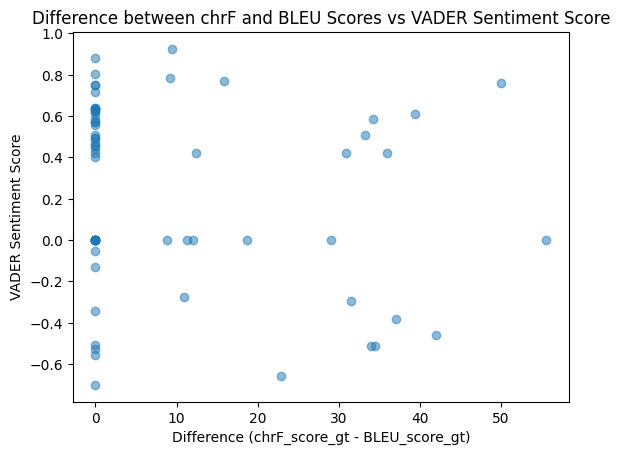

In [ ]:
plt.scatter(df_both_true['score_difference'], df_both_true['true_sentiment_value'], alpha=0.5)
plt.xlabel('Difference (chrF_score_gt - BLEU_score_gt)')
plt.ylabel('True Sentiment Value')
plt.title('Difference between chrF and BLEU Scores vs True Sentiment Value')
plt.show()

plt.scatter(df_both_true['score_difference'], df_both_true['VADER_google_sa'], alpha=0.5)
plt.xlabel('Difference (chrF_score_gt - BLEU_score_gt)')
plt.ylabel('VADER Sentiment Score')
plt.title('Difference between chrF and BLEU Scores vs VADER Sentiment Score')
plt.show()


Correlation coefficient: 0.92


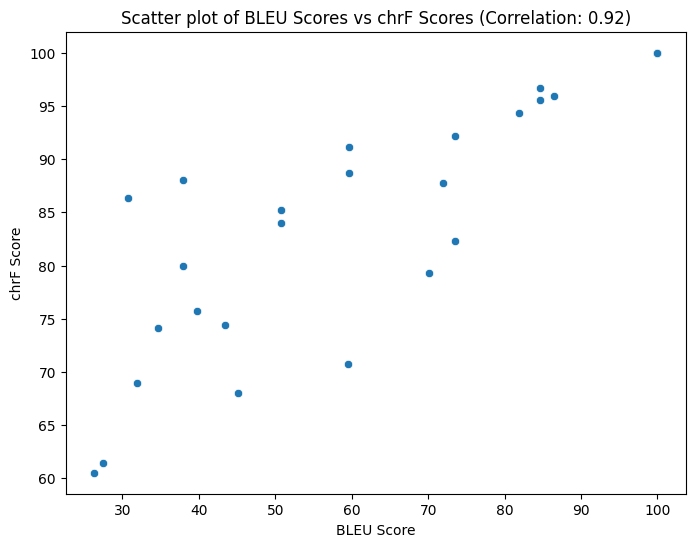

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# Assuming your DataFrame is named df_both_true, and you have 'BLEU_score_gt' and 'chrF_score_gt' columns
bleu_scores = df_both_true['BLEU_score_gt']
chrf_scores = df_both_true['chrF_score_gt']

# Calculate the correlation coefficient
correlation_coefficient = bleu_scores.corr(chrf_scores)
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=bleu_scores, y=chrf_scores)
plt.xlabel('BLEU Score')
plt.ylabel('chrF Score')
plt.title(f'Scatter plot of BLEU Scores vs chrF Scores (Correlation: {correlation_coefficient:.2f})')

# Show the plot
plt.show()


Polarity Graph examples

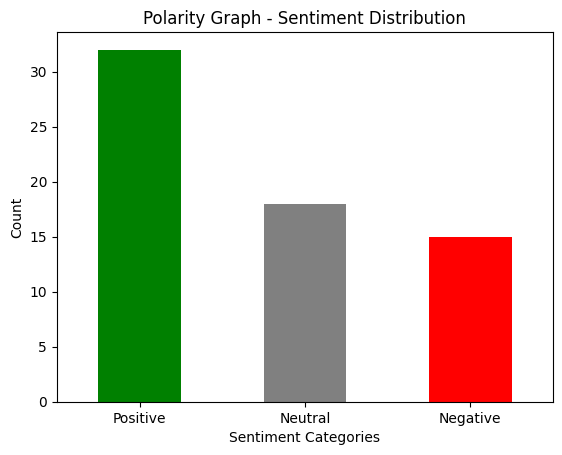

In [ ]:
# Count the sentiment categories
sentiment_counts = df_both_true['true_sentiment'].value_counts()

# Create a bar plot
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'], rot=0)
plt.xlabel('Sentiment Categories')
plt.ylabel('Count')
plt.title('Polarity Graph - Sentiment Distribution')

# Show the plot
plt.show()


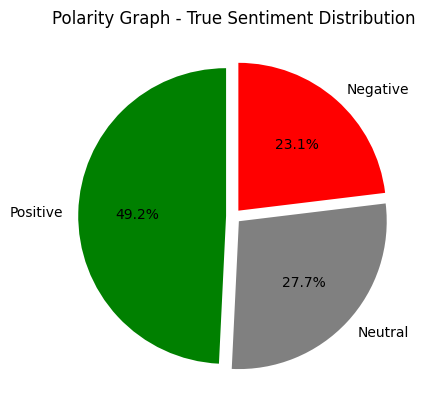

In [ ]:
# Count the sentiment categories
sentiment_counts = df_both_true['true_sentiment'].value_counts()

# Create a pie chart
colors = ['green', 'gray', 'red']
explode = (0.05, 0.05, 0.05)  # offset each slice slightly
sentiment_counts.plot(kind='pie', colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)

# Add a title and remove the y-axis label
plt.title('Polarity Graph - True Sentiment Distribution')
plt.ylabel('')

# Show the plot
plt.show()


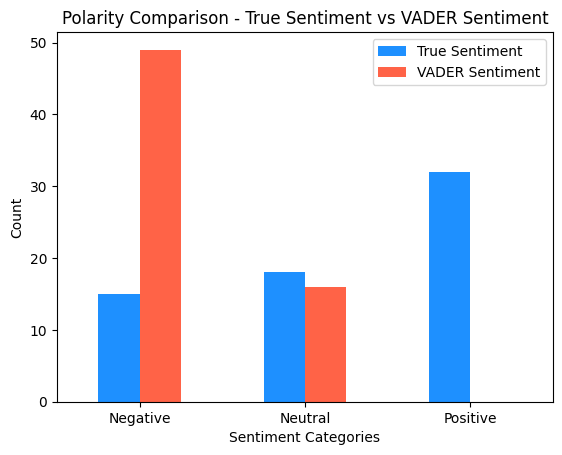

In [ ]:

# Count the sentiment categories for true sentiment and VADER sentiment
true_sentiment_counts = df_both_true['true_sentiment'].value_counts()
vader_sentiment_counts = df_both_true['VADER_google_sa'].apply(lambda x: 'Positive' if x == 1 else ('Neutral' if x == 0 else 'Negative')).value_counts()

# Create a DataFrame with the counts for both true and VADER sentiment
sentiment_comparison_df = pd.DataFrame({'True Sentiment': true_sentiment_counts, 'VADER Sentiment': vader_sentiment_counts})

# Create side-by-side bar plots
ax = sentiment_comparison_df.plot(kind='bar', color=['dodgerblue', 'tomato'], rot=0)

# Set labels and title
plt.xlabel('Sentiment Categories')
plt.ylabel('Count')
plt.title('Polarity Comparison - True Sentiment vs VADER Sentiment')

# Configure legend and show the plot
plt.legend(loc='upper right')
plt.show()

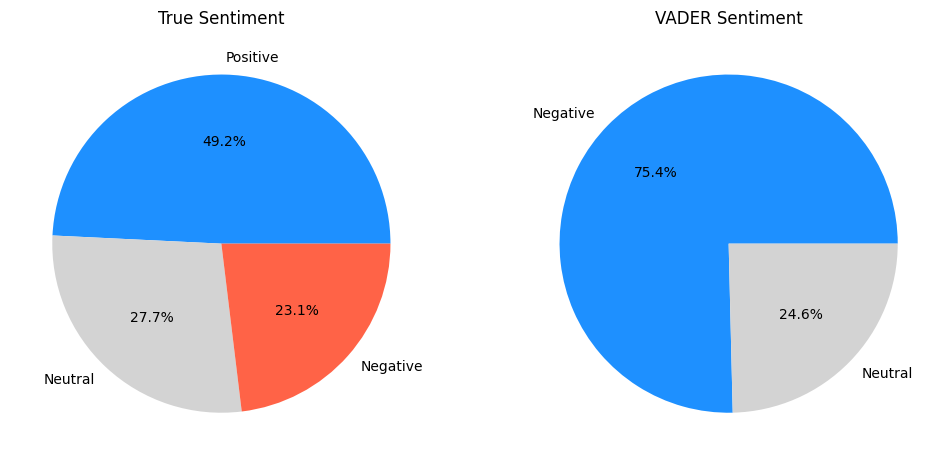

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie plot for True Sentiment
true_sentiment_counts.plot(kind='pie', autopct='%.1f%%', colors=['dodgerblue', 'lightgray', 'tomato'], ax=axes[0])
axes[0].set_title('True Sentiment')
axes[0].set_ylabel('')

# Pie plot for VADER Sentiment
vader_sentiment_counts.plot(kind='pie', autopct='%.1f%%', colors=['dodgerblue', 'lightgray', 'tomato'], ax=axes[1])
axes[1].set_title('VADER Sentiment')
axes[1].set_ylabel('')

# Display the plots
plt.show()


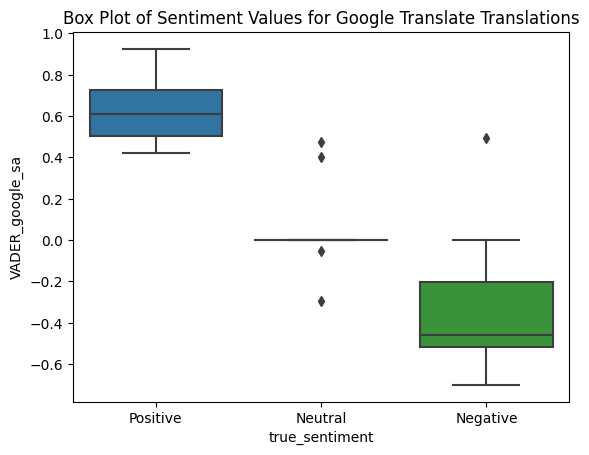

In [ ]:
#  vader_sentiment vs is Google vader sentiment

# Box plot of the sentiment values, grouped by the 'true_sentiment' values for Google Translate translations
sns.boxplot(x='true_sentiment', y='VADER_google_sa', data=df_both_true)
plt.title('Box Plot of Sentiment Values for Google Translate Translations')
plt.show()


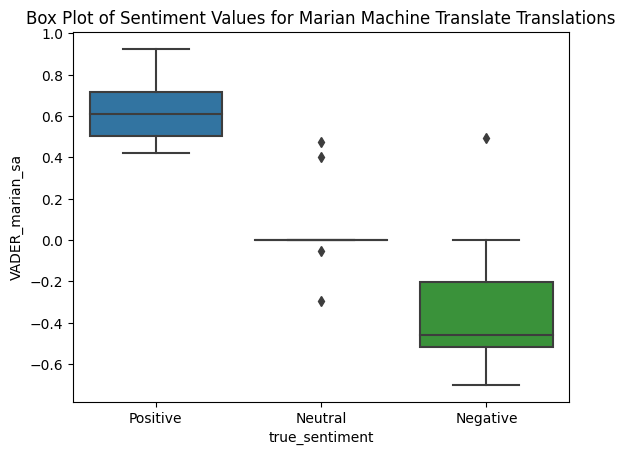

In [ ]:
# Box plot of the sentiment values, grouped by the 'true_sentiment' values for Marian Translate translations
sns.boxplot(x='true_sentiment', y='VADER_marian_sa', data=df_both_true)
plt.title('Box Plot of Sentiment Values for Marian Machine Translate Translations')
plt.show()

### Qualatative Examples and analysis


In [ ]:
# Number of examples to select
n_examples = 5

# Find indices of the highest and lowest sentiment scores
highest_sentiment_indices = df_both_true["true_sentiment_value"].nlargest(n_examples).index
lowest_sentiment_indices = df_both_true["true_sentiment_value"].nsmallest(n_examples).index

# Combine indices
interesting_indices = highest_sentiment_indices.union(lowest_sentiment_indices)

# Display interesting examples
for i in interesting_indices:
    print(f'Sentence: {df_both_true.loc[i]["Italian"]}')
    print(f'Google Translation: {df_both_true.loc[i]["English_Google"]}')
    print(f'MT Translation: {df_both_true.loc[i]["English_opus-mt-tc-big-it-en"]}')
    print(f'True Sentiment: {df_both_true.loc[i]["true_sentiment"]}')
    print(f'True Sentiment Value: {df_both_true.loc[i]["true_sentiment_value"]}')
    print(f'BLEU Score (Google): {df_both_true.loc[i]["BLEU_score_gt"]}')
    print(f'BLEU Score (Marian): {df_both_true.loc[i]["BLEU_score_mt"]}')
    print(f'chrF Score (Google): {df_both_true.loc[i]["chrF_score_gt"]}')
    print(f'chrF Score (Marian): {df_both_true.loc[i]["chrF_score_mt"]}')
    print('-' * 40)


Sentence: Avere un buon amico rende la vita piÃ¹ bella
Google Translation: Having a good friend makes life more beautiful
MT Translation: Having a good friend makes life more beautiful
True Sentiment: Positive
True Sentiment Value: 1.0
BLEU Score (Google): 100.0
BLEU Score (Marian): 100.0
chrF Score (Google): 100.0
chrF Score (Marian): 100.0
----------------------------------------
Sentence: Quando passeggio tra la natura mi sento sempre felice e rilassata
Google Translation: When I walk between nature I always feel happy and relaxed
MT Translation: When I walk through nature I always feel happy and relaxed
True Sentiment: Positive
True Sentiment Value: 1.0
BLEU Score (Google): 70.17
BLEU Score (Marian): 100.0
chrF Score (Google): 79.3
chrF Score (Marian): 100.0
----------------------------------------
Sentence: Viaggiare in treno da sola è un esperienza bellissima ed estremamente rilassante
Google Translation: Traveling by train alone is a beautiful and extremely relaxing experience
M

## Flair

Flair only has postive and negative sentiment. No neutral so we have to remove the neutral from the comparisons.

Machine learning models training for classification. postive negative vs neutral.

Only compare based on only postiive and negative.

Classify -1 or 1. Positive or negative.
When each category is compared to same category for each the translations.

* 1 channel
* No 0
* -1 channel

Confusion matrix of 2x2




* Preprocess data: Clean and preprocess the text data for Flair. This may include tokenization, lowercasing, and removing special characters or numbers.

* Flair setup: Install and set up Flair, load the appropriate pre-trained sentiment analysis model, and create a function to apply the model on the preprocessed text.
  * Flair data was already collected
  * Identify the Flair fields for analysis

  ```


  ```

* Apply Flair on translations: Apply the Flair model on the translations generated by both Google Translate (GT) and Marian MT.

* Evaluate Flair accuracy: Compare the sentiment predictions by Flair against the true sentiment labels to evaluate the accuracy of Flair on both GT and MT translations.

* Compare translation quality: Analyze the quality of the translations for both GT and MT using metrics like BLEU and chrF.

* Visualize results: Create visualizations to compare the quality and sentiment analysis results for both GT and MT translations.

* Analyze interesting cases: Identify and analyze interesting cases where there are discrepancies in the sentiment analysis or translation quality.



In [ ]:
# Review the Flair columns

# Filter the columns containing the word "Flair"
flair_columns = df_both_true.filter(like='Flair')
print(flair_columns)



         FlairSentiment    FlairSentiment-G
61    POSITIVE (0.9925)   POSITIVE (0.9911)
62    POSITIVE (0.9827)    POSITIVE (0.956)
52    POSITIVE (0.9978)   POSITIVE (0.9978)
133   POSITIVE (0.5808)   POSITIVE (0.8226)
121   POSITIVE (0.9974)   POSITIVE (0.9987)
..                  ...                 ...
65    NEGATIVE (0.9996)   NEGATIVE (0.9996)
25    POSITIVE (0.9995)   POSITIVE (0.9995)
1     POSITIVE (0.9925)   POSITIVE (0.9925)
78    NEGATIVE (0.9999)   NEGATIVE (0.9998)
35    POSITIVE (0.9992)   POSITIVE (0.9992)

[65 rows x 2 columns]


In [ ]:
# Rename the columns
df_both_true = df_both_true.rename(columns={
    'FlairSentiment': 'FlairSentiment_MT',
    'FlairSentiment-G': 'FlairSentiment_GT'
})

df_both_true = df_both_true.rename(columns={
    'English_opus-mt-tc-big-it-en': 'English_MT'})

In [ ]:
# Filter the columns containing the word "Flair"
flair_columns = df_both_true.filter(like='Flair')
print(flair_columns)

      FlairSentiment_MT   FlairSentiment_GT
61    POSITIVE (0.9925)   POSITIVE (0.9911)
62    POSITIVE (0.9827)    POSITIVE (0.956)
52    POSITIVE (0.9978)   POSITIVE (0.9978)
133   POSITIVE (0.5808)   POSITIVE (0.8226)
121   POSITIVE (0.9974)   POSITIVE (0.9987)
..                  ...                 ...
65    NEGATIVE (0.9996)   NEGATIVE (0.9996)
25    POSITIVE (0.9995)   POSITIVE (0.9995)
1     POSITIVE (0.9925)   POSITIVE (0.9925)
78    NEGATIVE (0.9999)   NEGATIVE (0.9998)
35    POSITIVE (0.9992)   POSITIVE (0.9992)

[65 rows x 2 columns]


Flair doesn't have a neutral value it only has positive and negative. So we need to only compare the Negative and the Positive true_sentiment. We have that information from the previous categorization technique.

Prepare a new dataset.

In [ ]:
# Filter the DataFrame to include only Positive and Negative true_sentiment values
df_flair = df_both_true[df_both_true['true_sentiment'].isin(['Positive', 'Negative'])]


In [ ]:
# Specify the columns you want to review
columns_to_review = ['Italian', 'English_Google', 'English_MT', 'true_sentiment', 'FlairSentiment_GT', 'FlairSentiment_MT']

# Display the first few rows of the selected columns
print(df_flair[columns_to_review].head())


                                              Italian  \
61  Mi sento una donna molto fortunate perchÃ¨ fac...   
62  Ieri ho visitato un museo d'arte molto interes...   
52  Viaggiare in treno da sola è un esperienza bel...   
51  Quando passeggio tra la natura mi sento sempre...   
24       Avere un buon amico rende la vita piÃ¹ bella   

                                       English_Google  \
61  I feel like a very lucky woman because I do a ...   
62  Yesterday I visited a very interesting art mus...   
52  Traveling by train alone is a beautiful and ex...   
51  When I walk between nature I always feel happy...   
24     Having a good friend makes life more beautiful   

                                           English_MT true_sentiment  \
61  I feel like a very lucky woman because I do a ...       Positive   
62  Yesterday I visited a very interesting art mus...       Positive   
52  Traveling by train alone is a beautiful and ex...       Positive   
51  When I walk through na

In [ ]:

def extract_flair_score(sentiment_str):
    score = re.findall(r'\((.*?)\)', sentiment_str)
    if score:
        return float(score[0])
    return None

# Apply the function to the Flair sentiment columns
df_flair['FlairScore_GT'] = df_flair['FlairSentiment_GT'].apply(extract_flair_score)
df_flair['FlairScore_MT'] = df_flair['FlairSentiment_MT'].apply(extract_flair_score)

# Preview the DataFrame with the new columns
print(df_flair[['FlairSentiment_GT', 'FlairScore_GT', 'FlairSentiment_MT', 'FlairScore_MT']].head())

     FlairSentiment_GT  FlairScore_GT   FlairSentiment_MT  FlairScore_MT
61   POSITIVE (0.9911)         0.9911   POSITIVE (0.9925)         0.9925
62    POSITIVE (0.956)         0.9560   POSITIVE (0.9827)         0.9827
52   POSITIVE (0.9978)         0.9978   POSITIVE (0.9978)         0.9978
51   POSITIVE (0.9976)         0.9976   POSITIVE (0.9978)         0.9978
24   POSITIVE (0.9985)         0.9985   POSITIVE (0.9985)         0.9985


In [ ]:
# Get 3 positive and 3 negative examples
positive_examples = df_flair[df_flair['true_sentiment'] == 'Positive'].head(3)
negative_examples = df_flair[df_flair['true_sentiment'] == 'Negative'].head(3)

# Combine the positive and negative examples
combined_examples = pd.concat([positive_examples, negative_examples])

# Specify the columns you want to review
columns_to_review = ['Italian', 'English_Google', 'English_MT', 'true_sentiment', 'FlairSentiment_GT', 'FlairSentiment_MT', 'FlairScore_GT', 'FlairScore_MT']

# Display the selected examples with the specified columns
print(combined_examples[columns_to_review])


                                              Italian  \
61  Mi sento una donna molto fortunate perchÃ¨ fac...   
62  Ieri ho visitato un museo d'arte molto interes...   
52  Viaggiare in treno da sola è un esperienza bel...   
77                Ho letto un libro orribile e noioso   
80                   Il cibo non era buono per niente   
67                       Non mi piace quello che dici   

                                       English_Google  \
61  I feel like a very lucky woman because I do a ...   
62  Yesterday I visited a very interesting art mus...   
52  Traveling by train alone is a beautiful and ex...   
77                  I read a horrible and boring book   
80                       The food was not good at all   
67                          I don't like what you say   

                                           English_MT true_sentiment  \
61  I feel like a very lucky woman because I do a ...       Positive   
62  Yesterday I visited a very interesting art mus...   

In [ ]:
# # Step 1: Preprocess data
# def preprocess_text(text):
#     # Implement preprocessing steps
#     pass

# # Step 2: Flair setup
# import flair
# # Load pre-trained sentiment model
# flair_sentiment_model = flair.models.TextClassifier.load('en-sentiment')
# def apply_flair(text):
#     # Apply Flair model on preprocessed text
#     pass

# # Step 3: Apply Flair on translations
# df_both_true['flair_sentiment_gt'] = df_both_true['English_Google'].apply(lambda x: apply_flair(preprocess_text(x)))
# df_both_true['flair_sentiment_mt'] = df_both_true['English_Marian'].apply(lambda x: apply_flair(preprocess_text(x)))

# Step 4: Evaluate Flair accuracy
# Calculate Flair accuracy for GT and MT translations

# Step 5: Compare translation quality
# Calculate BLEU and chrF scores for GT and MT translations

# Step 6: Visualize results
# Create visualizations for translation quality and sentiment analysis results

# Step 7: Analyze interesting cases
# Identify and analyze interesting cases with discrepancies in sentiment analysis or translation quality


In [ ]:
df_flair[['FlairScore_MT','FlairScore_GT']].head()

,FlairScore_MT,FlairScore_GT
61,0.9925,0.9911
62,0.9827,0.9560
52,0.9978,0.9978
51,0.9978,0.9976
24,0.9985,0.9985


In [ ]:
#Set up the data for analysing Flair
# df_flair['FlairSentiment_MT'].value_counts()
# df_flair['FlairSentiment_GT'].value_counts()



### Prepare Flair


In [ ]:
# Calculate text length
df_flair['text_length'] = df_flair['Italian'].apply(lambda x: len(x))


### Text length

* Italian sentence length
* Google Translation length
* Marian MT Translation length


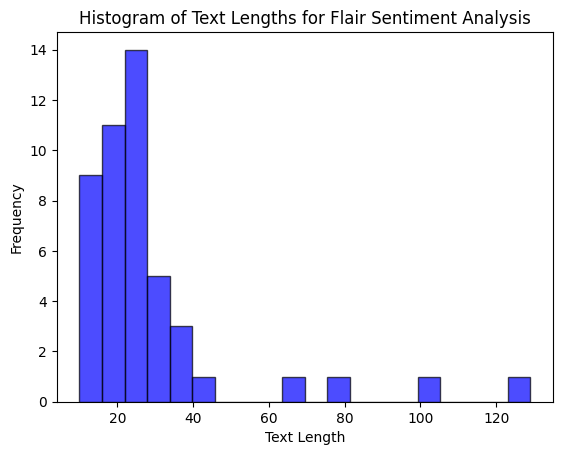

In [ ]:

# Plot histogram of text lengths
plt.hist(df_flair['text_length'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths for Flair Sentiment Analysis')
plt.show()


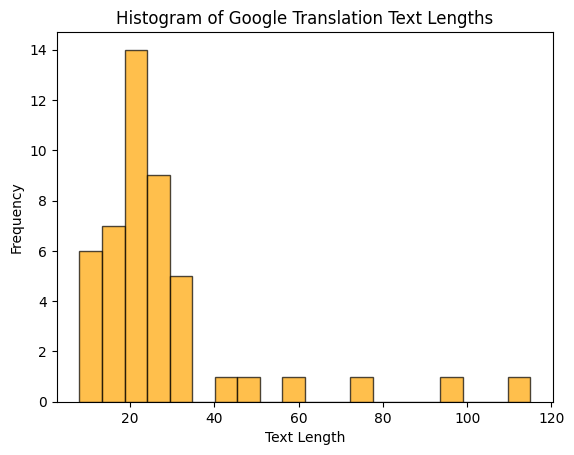

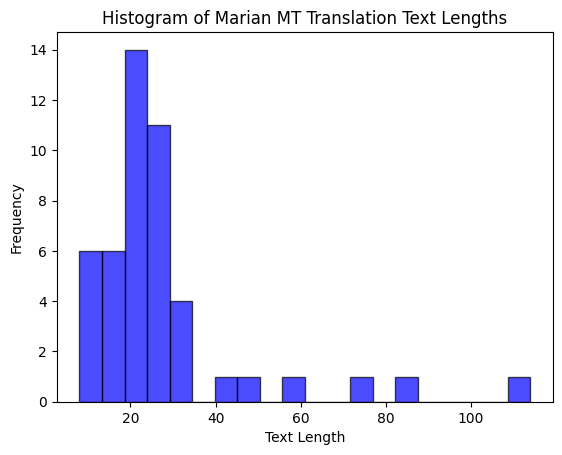

In [ ]:
# Calculate text lengths
df_flair['google_translation_length'] = df_flair['English_Google'].apply(lambda x: len(x))
df_flair['mt_translation_length'] = df_flair['English_MT'].apply(lambda x: len(x))

# Plot histogram of Google Translation text lengths
plt.hist(df_flair['google_translation_length'], bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Google Translation Text Lengths')
plt.show()

# Plot histogram of Marian MT Translation text lengths
plt.hist(df_flair['mt_translation_length'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Marian MT Translation Text Lengths')
plt.show()


### Word Frequeny
* Google Translation frequency
* Marian MT Translation frequency

Does word frequency affect translation quality or sentiment detection?

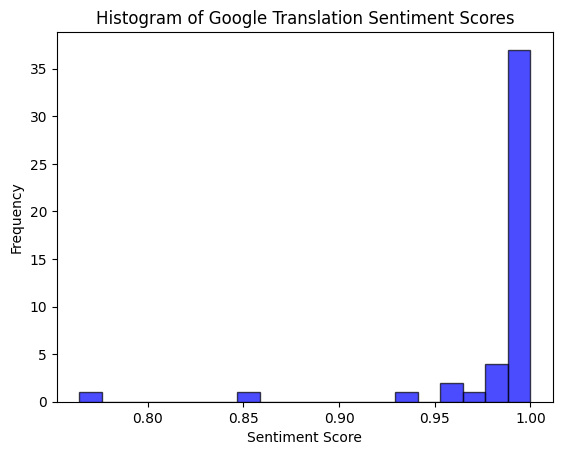

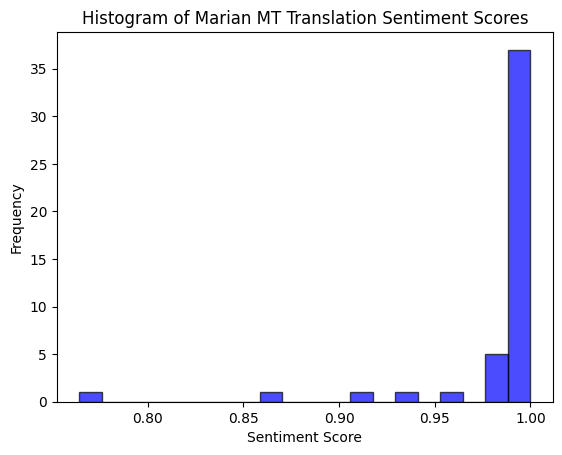

In [ ]:
# Plot histogram of Google Translation sentiment scores
plt.hist(df_flair['FlairScore_GT'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Google Translation Sentiment Scores')
plt.show()

# Plot histogram of Marian MT Translation sentiment scores
plt.hist(df_flair['FlairScore_MT'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Marian MT Translation Sentiment Scores')
plt.show()



### Word Sequences
* Google Translation frequency
* Marian MT Translation frequency

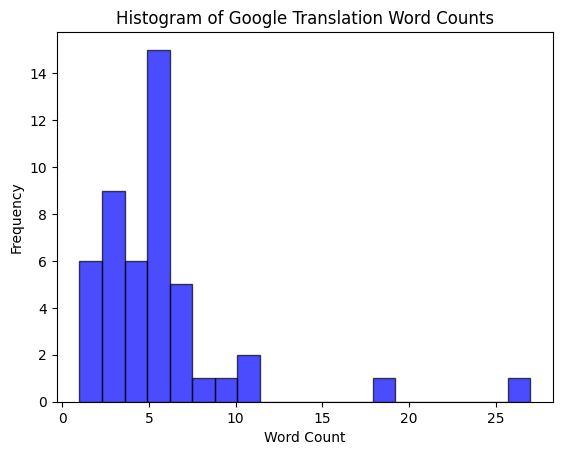

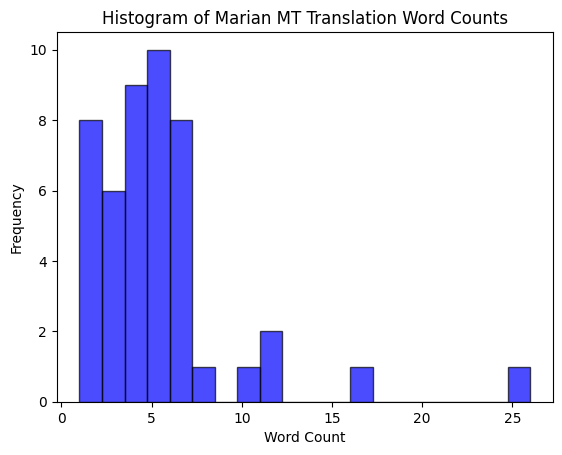

In [ ]:
# Add a new column for word counts of Google and MT Translations
df_flair['word_count_GT'] = df_flair['English_Google'].apply(lambda x: len(x.split()))
df_flair['word_count_MT'] = df_flair['English_MT'].apply(lambda x: len(x.split()))

# Plot histogram of Google Translation word counts
plt.hist(df_flair['word_count_GT'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Google Translation Word Counts')
plt.show()

# Plot histogram of Marian MT Translation word counts
plt.hist(df_flair['word_count_MT'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Marian MT Translation Word Counts')
plt.show()



### Overall Quality with chrF and BLEU scores and correlation to Flair scores
* Google Translation chrF
* Marian MT Translation BLEU


Correlation between Google Translation chrF score and Flair score: -0.020723000417525606
Correlation between Marian MT Translation BLEU score and Flair score: nan


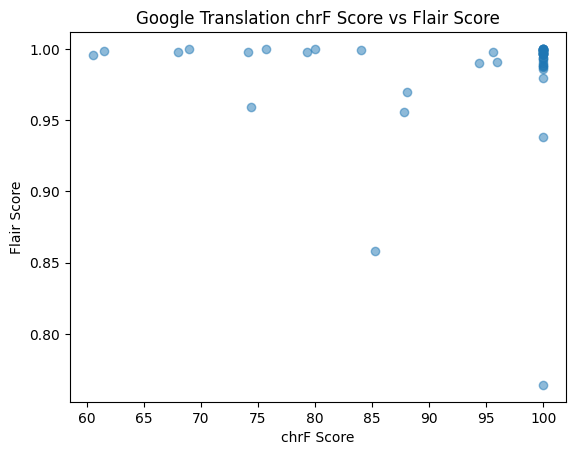

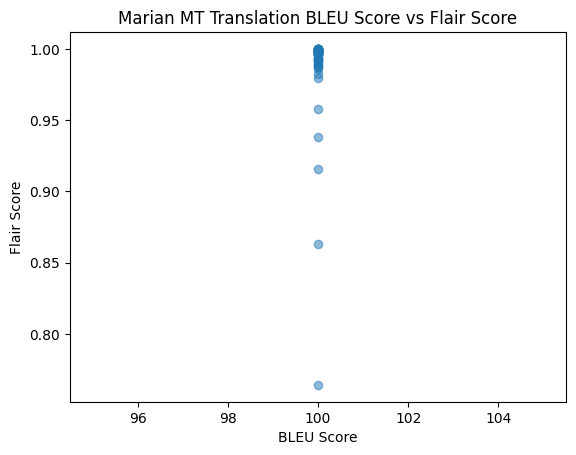

In [ ]:
# Calculate the correlation between chrF/BLEU scores and Flair scores
correlation_chrF_GT_Flair = df_flair['chrF_score_gt'].corr(df_flair['FlairScore_GT'])
correlation_BLEU_MT_Flair = df_flair['BLEU_score_mt'].corr(df_flair['FlairScore_MT'])

print("Correlation between Google Translation chrF score and Flair score:", correlation_chrF_GT_Flair)
print("Correlation between Marian MT Translation BLEU score and Flair score:", correlation_BLEU_MT_Flair)

# Scatter plot for Google Translation chrF score and Flair score
plt.scatter(df_flair['chrF_score_gt'], df_flair['FlairScore_GT'], alpha=0.5)
plt.xlabel('chrF Score')
plt.ylabel('Flair Score')
plt.title('Google Translation chrF Score vs Flair Score')
plt.show()

# Scatter plot for Marian MT Translation BLEU score and Flair score
plt.scatter(df_flair['BLEU_score_mt'], df_flair['FlairScore_MT'], alpha=0.5)
plt.xlabel('BLEU Score')
plt.ylabel('Flair Score')
plt.title('Marian MT Translation BLEU Score vs Flair Score')
plt.show()







### Qualitative Examples



In [ ]:
# Number of examples to select
n_examples = 5

# Find indices of the highest and lowest Flair sentiment scores for Google Translations
highest_sentiment_indices_gt = df_flair["FlairScore_GT"].nlargest(n_examples).index
lowest_sentiment_indices_gt = df_flair["FlairScore_GT"].nsmallest(n_examples).index

# Find indices of the highest and lowest Flair sentiment scores for MT Translations
highest_sentiment_indices_mt = df_flair["FlairScore_MT"].nlargest(n_examples).index
lowest_sentiment_indices_mt = df_flair["FlairScore_MT"].nsmallest(n_examples).index

# Combine indices
interesting_indices_gt = highest_sentiment_indices_gt.union(lowest_sentiment_indices_gt)
interesting_indices_mt = highest_sentiment_indices_mt.union(lowest_sentiment_indices_mt)

# Display interesting examples for Google Translations
print("Interesting examples for Google Translations:")
for i in interesting_indices_gt:
    print(f'Sentence: {df_flair.loc[i]["Italian"]}')
    print(f'Google Translation: {df_flair.loc[i]["English_Google"]}')
    print(f'True Sentiment: {df_flair.loc[i]["true_sentiment"]}')
    print(f'Flair Sentiment: {df_flair.loc[i]["FlairSentiment_GT"]}')
    print(f'Flair Sentiment Score: {df_flair.loc[i]["FlairScore_GT"]}')
    print('-' * 40)

print("\nInteresting examples for MT Translations:")
# Display interesting examples for MT Translations
for i in interesting_indices_mt:
    print(f'Sentence: {df_flair.loc[i]["Italian"]}')
    print(f'MT Translation: {df_flair.loc[i]["English_MT"]}')
    print(f'True Sentiment: {df_flair.loc[i]["true_sentiment"]}')
    print(f'Flair Sentiment: {df_flair.loc[i]["FlairSentiment_MT"]}')
    print(f'Flair Sentiment Score: {df_flair.loc[i]["FlairScore_MT"]}')
    print('-' * 40)


Interesting examples for Google Translations:
Sentence: È stato bello parlare con te
Google Translation: It has been nice talking to you
True Sentiment: Positive
Flair Sentiment:  POSITIVE (0.959)
Flair Sentiment Score: 0.959
----------------------------------------
Sentence: Ieri ho visitato un museo d'arte molto interessante e mi Ã¨ piaciuto moltissimo, ci voglio ritornare!
Google Translation: Yesterday I visited a very interesting art museum and I liked it very much, I want to go back!
True Sentiment: Positive
Flair Sentiment:  POSITIVE (0.956)
Flair Sentiment Score: 0.956
----------------------------------------
Sentence: Questo è un grosso guaio!
Google Translation: This is a big trouble!
True Sentiment: Negative
Flair Sentiment:  NEGATIVE (0.9996)
Flair Sentiment Score: 0.9996
----------------------------------------
Sentence: Che delusione!
Google Translation: What a disappointment!
True Sentiment: Negative
Flair Sentiment:  NEGATIVE (1.0)
Flair Sentiment Score: 1.0
------------

The interesting thing here is that the selections are positive matched with postive and negative with negative. However, the neutral classifed as other classes is not looked at.



## Comparisons

In [ ]:
print("Filtered rows:", len(df_flair))
print("Unique values in true_sentiment column:", df_flair['true_sentiment'].unique())


Filtered rows: 47
Unique values in true_sentiment column: ['Positive' 'Negative']


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Filter rows based on 'true_sentiment'
df_flair_filtered = df_flair[df_flair['true_sentiment'].isin(['Positive', 'Negative'])]

# Calculate the residuals/differences for Flair scores
df_flair_filtered["residual_google_flair"] = df_flair_filtered["true_sentiment_value"] - df_flair_filtered["FlairScore_GT"]
df_flair_filtered["residual_mt_flair"] = df_flair_filtered["true_sentiment_value"] - df_flair_filtered["FlairScore_MT"]

# Display the confusion matrix as a heat map for Google Translations
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_gt, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for Google Translations (Flair Sentiment)')
plt.show()

# Display the confusion matrix as a heat map for MT Translations
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_mt, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for MT Translations (Flair Sentiment)')
plt.show()


NameError: ignored

<Figure size 800x600 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the true sentiments and Flair sentiment predictions for Google and MT translations
true_sentiments = df_flair_filtered['true_sentiment']
flair_sentiments_gt = df_flair_filtered['FlairSentiment_GT']
flair_sentiments_mt = df_flair_filtered['FlairSentiment_MT']

# Create confusion matrices for Google and MT translations
confusion_matrix_gt = confusion_matrix(true_sentiments, flair_sentiments_gt, labels=['Positive', 'Negative'])
confusion_matrix_mt = confusion_matrix(true_sentiments, flair_sentiments_mt, labels=['Positive', 'Negative'])

# Display the confusion matrix as a heat map for Google Translations
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_gt, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for Google Translations (Flair Sentiment)')
plt.show()

# Display the confusion matrix as a heat map for MT Translations
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_mt, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for MT Translations (Flair Sentiment)')
plt.show()


## Naturla Language Toolkit (NLTK)
https://www.nltk.org/howto/sentiment.html

NLTK has Negative, Neutral, Postiive, Compound  values.

```NLTKPositive                     169 non-null    float64
 9   NLTKNegative                     169 non-null    float64
 10  NLTKNeutral                      169 non-null    float64
 11  NLTKSentiment                    169 non-null    float64
 12  NLTKPositive-G                   169 non-null    float64
 13  NLTKNegative-G                   169 non-null    float64
 14  NLTKNeutral-G                    169 non-null    float64
 15  NLTKSentiment-G                  169 non-null    float64
```


### Prepare NLTK Data

In [ ]:
#Set up NLTK reivew

nltk_cols = ['Original','NLTKNegative','NLTKNeutral','NLTKSentiment','NLTKPositive-G','NLTKNegative-G','NLTKNeutral-G','NLTKSentiment-G']
df[nltk_cols].head()


In [ ]:
# filter the DataFrame for negative sentiment
df_negative = df.loc[df['Original'] == -1]
print(df_negative[nltk_cols].head())

# filter the DataFrame for neutral sentiment
df_neutral = df.loc[df['Original'] == 0]
print(df_neutral[nltk_cols].head())

# filter the DataFrame for positive sentiment
df_positive = df.loc[df['Original'] == 1]
print(df_positive[nltk_cols].head())


### NLTK Google Translate

In [ ]:
#set up Google Translate columns to examine

nltk_cols_google = ['Original','NLTKPositive-G','NLTKNegative-G','NLTKNeutral-G','NLTKSentiment-G']
df[nltk_cols_google].head()

In [ ]:
# Combine NLTK Google Translate move sentiment values into one column

df["nltk_sentiment"] = df["NLTKSentiment-G"].apply(label_sentiment)

In [ ]:
# group by the labeled nltk_sentiment and count
df_grouped = df.groupby("nltk_sentiment")
df["nltk_sentiment"].value_counts()

In [ ]:
# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["nltk_sentiment"], margins=True)
print(confusion_matrix)

In [ ]:
# Create a confusion matrix using the crosstab function
nltk_gt_confusion_matrix = pd.crosstab(df[gold_sentiment], df["nltk_sentiment"], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(nltk_gt_confusion_matrix, annot=True, fmt='d', cmap='Reds')

# Add a title
plt.title('Confusion Matrix NLTK Google Translate')

# Show the plot
plt.show()

In [ ]:

# Create a data frame that contains the 'sentiment' and 'sent_g' values for each row in the original data frame
sentiment_df = df[['nltk_sentiment', gold_sentiment]].copy()
sentiment_df.info()

# Display a box plot of the sentiment values, grouped by the 'gold sentiment' values
sns.boxplot(x=gold_sentiment, y='nltk_sentiment', data=sentiment_df)

# Title
plt.title('Box Plot of Sentiment Values')

# Show the plot
plt.show()

In [ ]:
df_grouped["word_count"].plot(kind="bar", title="Sentence word count by Sentiment")


In [ ]:
# Create a box plot
ax = df_grouped.boxplot(column="word_count", by="Original")

# Show the plot
plt.show()

### Text length
### Word Frequeny
### Word Sequences
### Overall Quality
### Examples of mis *translation*

## Comparisons



### NLTK Marian MT


In [ ]:
#set up Marian MT columns to examine

nltk_cols_mt = ['Original','NLTKPositive','NLTKNegative','NLTKNeutral','NLTKSentiment']
df[nltk_cols_mt].head()

In [ ]:
# Combine NLTK Google Translate move sentiment values into one column

df["nltk_sentiment"] = df["NLTKSentiment"].apply(label_sentiment)

In [ ]:
# group by the labeled nltk_sentiment and count
df_grouped = df.groupby("nltk_sentiment")
df["nltk_sentiment"].value_counts()

In [ ]:
# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["nltk_sentiment"], margins=True)
print(confusion_matrix)

In [ ]:
# Create a confusion matrix using the crosstab function
nltk_mt_confusion_matrix = pd.crosstab(df[gold_sentiment], df["nltk_sentiment"], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(nltk_mt_confusion_matrix, annot=True, fmt='d', cmap='Reds')

# Add a title
plt.title('Confusion Matrix NLTK Marian Machine Translate')

# Show the plot
plt.show()

### Text length
### Word Frequeny
### Word Sequences
### Overall Quality
### Examples of mis *translation*

## Comparisons



## [Text Blob](https://textblob.readthedocs.io/en/dev/)

Text blob's key values are:
* Polarity
* Subjectivity

Polarity is a float value within the range of [-1,1] where 1 means a positive sentiment, -1 means a negative sentiment and 0 means a neutral sentiment. It represents the overall emotion of a text.

Subjectivity is a float value within the range of [0,1] where 0 means objective and 1 means subjective. It represents the level of personal opinions and emotions in a text. A text with a high subjectivity score is likely to contain personal opinions and emotions, while a text with a low subjectivity score is likely to be more objective and factual.

```
 16  TextblobSentimentPolarity        169 non-null    float64
 17  TextblobSentimentSubjectivity    169 non-null    float64
 18  TextblobSentimentPolarity-G      169 non-null    float64
 19  TextblobSentimentSubjectivity-G  169 non-null    float64
 ```

### Prepare Text Blob Data

In [ ]:
# Set up the text blob data

#Set up Text Blob reivew

text_blob__cols = ["Original","TextblobSentimentPolarity","TextblobSentimentSubjectivity","TextblobSentimentPolarity-G","TextblobSentimentSubjectivity-G"]
df[text_blob__cols].head()

### Text Blob Google Translate

In [ ]:
# Combine Text Blob Google Translate move sentiment values into one column
df["textblob_gt_sentiment"] = df['TextblobSentimentPolarity-G'].apply(label_sentiment)
# group by the labeled vader_sentiment and count
df_grouped = df.groupby("textblob_gt_sentiment")
df["textblob_gt_sentiment"].value_counts()


In [ ]:
# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["textblob_gt_sentiment"], margins=True)
print(confusion_matrix)

In [ ]:
# Make sure to exclude bad translations and then possible compare for each translation.
# Will have to make sure that matching rows are compared.
# If we have sentences 3 wrong from marian and 3 in ops. We lose 6.
# When looking at the data set indepently we only lose the ones from that see.


# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["textblob_gt_sentiment"], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')

# Add a title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Text Blob Marian Machine Tranlsate

In [ ]:
# Combine Text Blob Marian Machine Translate move sentiment values into one column
df["textblob_mt_sentiment"] = df['TextblobSentimentPolarity'].apply(label_sentiment)
# group by the labeled vader_sentiment and count
df_grouped = df.groupby("textblob_mt_sentiment")
df["textblob_mt_sentiment"].value_counts()


In [ ]:
# Make sure to exclude bad translations and then possible compare for each translation.
# Will have to make sure that matching rows are compared.
# If we have sentences 3 wrong from marian and 3 in ops. We lose 6.
# When looking at the data set indepently we only lose the ones from that see.


# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["textblob_mt_sentiment"], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')

# Add a title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Text length
### Word Frequeny
### Word Sequences
### Overall Quality
### Examples of mis *translation*

## Comparisons

## Pattern

```
22  PatternSentimentPolarity         169 non-null    float64
 23  PatternSentimentSubjectivity     169 non-null    float64
 24  PatternSentimentPolarity-G       169 non-null    float64
 25  PatternSentimentSubjectivity-G   169 non-null    float64
 ```


### Prepare Pattern Data

In [ ]:
# Set up the text blob data

#Set up Text Blob reivew

text_blob__cols = ["Original","PatternSentimentPolarity","PatternSentimentSubjectivity","PatternSentimentPolarity-G","PatternSentimentSubjectivity-G"]
df[text_blob__cols].head()

### Pattern Google Translate

In [ ]:
# Combine Pattern Google Translate move sentiment values into one column
df["pattern_gt_sentiment"] = df['PatternSentimentPolarity-G'].apply(label_sentiment)
# group by the labeled vader_sentiment and count
df_grouped = df.groupby("pattern_gt_sentiment")
df["pattern_gt_sentiment"].value_counts()

In [ ]:
# Combine Text Blob Marian Machine Translate move sentiment values into one column
df["pattern_gt_sentiment"] = df['PatternSentimentPolarity-G'].apply(label_sentiment)
# group by the labeled vader_sentiment and count
df_grouped = df.groupby("pattern_gt_sentiment")
df["pattern_gt_sentiment"].value_counts()
# Make sure to exclude bad translations and then possible compare for each translation.
# Will have to make sure that matching rows are compared.
# If we have sentences 3 wrong from marian and 3 in ops. We lose 6.
# When looking at the data set indepently we only lose the ones from that see.


# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["pattern_gt_sentiment"], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')

# Add a title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

### Pattern Marian Machine Translate

In [ ]:
# Combine Pattern Marian Machine Translate move sentiment values into one column
df["pattern_mt_sentiment"] = df['PatternSentimentPolarity'].apply(label_sentiment)
# group by the labeled vader_sentiment and count
df_grouped = df.groupby("pattern_mt_sentiment")
df["pattern_mt_sentiment"].value_counts()

In [ ]:
# Combine Pattern Marian Machine Translate move sentiment values into one column
df["pattern_mt_sentiment"] = df['PatternSentimentPolarity'].apply(label_sentiment)
# group by the labeled vader_sentiment and count
df_grouped = df.groupby("pattern_mt_sentiment")
df["pattern_mt_sentiment"].value_counts()
# Make sure to exclude bad translations and then possible compare for each translation.
# Will have to make sure that matching rows are compared.
# If we have sentences 3 wrong from marian and 3 in ops. We lose 6.
# When looking at the data set indepently we only lose the ones from that see.


# Create a confusion matrix using the crosstab function
confusion_matrix = pd.crosstab(df[gold_sentiment], df["pattern_mt_sentiment"], margins=True)

# Display the confusion matrix as a heat map
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')

# Add a title
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
def create_confusion_matrix(df, gold_sentiment, target_sentiment):
    # Create a confusion matrix using the crosstab function
    confusion_matrix = pd.crosstab(df[gold_sentiment], df[target_sentiment], margins=True)

    # Display the confusion matrix as a heat map
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds')

    # Add a title
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

# Create the confusion matrix using the function
create_confusion_matrix(df, 'gold_sentiment', 'pattern_mt_sentiment')


### Text length
### Word Frequeny
### Word Sequences
### Overall Quality
### Examples of mis *translation*

## Comparisons

Text lenth
Word Frequeny
Word Sequences
Overall Quality
Examples of mis translation

Need to do row by row comparison

In Italian, then translation

Do a Bleu score for translation. Pick f1 or nist but compare it to the known bleu on marian.

* SHould we keep highquality translations
* How much of original statement should be kept?



=== seperate == topic move to other space
Consider using named entity analysis as another way to check the quality of the translatiosn and if the subjects or entities affect the sentimement more than less important elements of sentences.


Word cloud uni, bi, trigram clouds
* frequence of each

Types of errors
* Tone
* Connotiation
* Translation
* Politeness
* Classification
* Uknown
* Sarcasm

====

Flair, do row matching for sure.

====

Vader

Accuracy
precision: How good the predication
Recall: moving right to left
f1 score: combo of preceigion and recall, accounts for weighting issues

Goal accuracy of over 80%


====

Analyse by length.  What length performed best?
how to clasify short, medium, long? Defintion of?
* 7, 8-14, longer
* Determine by number tokens tokens


* Review the stop words in each of the sentences
* Named-Entity-Recognition


What about only using the two categories for VADER?
* Remove VADER from the Flair results
* Flair from VADER

Then the remain set

In English what is the expected accuracy of Flair and VADER?

https://pub.towardsai.net/sentiment-analysis-without-modeling-textblob-vs-vader-vs-flair-657b7af855f4

This example looks at Amazon reviews, they found VADER has an accuracy of 77% while Flair has a 95% accuracy rating


====

Typos and misspellings
Piloteness
Nuance in long and short sentences

====

K nearest neigbor might be helpful

====
Which length has the most errors in sentiment detection?

translation metric
* BLEU
* chrF2
* This is used by Marian MT

Can use this to create a loss function. Can be used to compare translators as well.

F1 or NIST a closer to human perception


Confusion matrix. False positives. What did they come from?

Show similar or different patterns of misidentification

sentimment model error
human judgement err
translator error
* combinmation of the adove errors

Need review on each of the sentences in the original Italian

How far from 0 is positive or negative?
* What is the zero band?
* What values of sentence are most inclusive.

How far BLEU was it from the MT model?


How dirty is the data set?

Still run on the data that is excluded

====

Word clouds in Original language


====

textblob, nltk, pattern

====

How many sentences for each sentiment?

====

How to measure how simular confusion matrices are to each other?


====
7, 8-14, +

=====

Distribute the sentences for comparision


====
On expert translated sentecnes what were the resutls for NLTK etc


====

Color coding to quick see postive, neg, nuetral

====

How happy are we with the translations and sentiments vs all the errors we're looking at?

====

Picking the wrong words. First one it finds as first.

====

Confidence in the tools?

====

In [ ]:
#character counts per translateion